# Préparation environnement d'expérimentation MLFlow

In [1]:
# Importation de MLflow pour la gestion des cycles de vie des modèles ML
import mlflow

# Configuration de l'URI de suivi MLflow
# Cette URI pointe vers l'instance MLflow en cours d'exécution, accessible localement.
# Elle permet d'enregistrer les métriques, paramètres, modèles, etc.

mlflow.set_tracking_uri('http://127.0.0.1:5000')


# Préparation du notebook 

Cette section du notebook est dédiée à l'installation des bibliothèques nécessaires et à la configuration initiale pour mener à bien notre analyse de données. Nous commençons par installer des bibliothèques spécifiques qui supportent divers aspects du traitement des données, de l'apprentissage automatique et de l'optimisation des modèles. Chaque bibliothèque a été choisie pour répondre à des besoins particuliers dans notre pipeline d'analyse.  

Nous importons ensuite les modules nécessaires pour le prétraitement des données, la modélisation, et l'évaluation des modèles. Ce préambule assure que toutes les ressources nécessaires sont prêtes à être utilisées pour le traitement et l'analyse de données complexes.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Standard Python Libraries

import os
import sys
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation and Basic Python Data Libraries

import numpy as np
import pandas as pd

# Statistical and Random Libraries

from scipy import stats
from scipy.stats import loguniform,uniform
from random import randint, uniform

# Machine Learning 

import sklearn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, learning_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Imbalanced-Learn Tools

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization Libraries

import matplotlib.pyplot as plt
import seaborn as sns

# Model Persistence Libraries

import joblib
from joblib import dump, load

# MLflow Integration

import mlflow
import mlflow.sklearn
from mlflow import sklearn as mlflow_sklearn
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient

# Optuna for Optimization

import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# SHAP for Model Interpretation

import shap

In [9]:
# Version Python 

print("Python version")
print(sys.version)

Python version
3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [10]:
# Versions des différences librairies

print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)
print("Joblib version:", joblib.__version__)
print("MLflow version:", mlflow.__version__)
print("Seaborn version:", sns.__version__)

Numpy version: 1.24.3
Pandas version: 1.5.3
Scikit-learn version: 1.4.2
XGBoost version: 2.0.3
Joblib version: 1.2.0
MLflow version: 2.12.2
Seaborn version: 0.12.2


In [11]:
# Paramétrage d'affichage des données

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [12]:
# Chargement des données 

df_information = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')

df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')

df_bureau = pd.read_csv('bureau.csv')
df_bureau_balance = pd.read_csv('bureau_balance.csv')

df_previous = pd.read_csv('previous_application.csv')

df_pos_cash = pd.read_csv('POS_CASH_balance.csv')

df_installments = pd.read_csv('installments_payments.csv')
df_credit_card = pd.read_csv ('credit_card_balance.csv')

In [13]:
train_file_path = "C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Data\\application_train_sample.joblib"
test_file_path = "C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Data\\application_test_sample.joblib"

# Echantillons de 5% des données
df_train_sample = df_train.sample(frac=0.05, random_state=42)
df_test_sample = df_test.sample(frac=0.05, random_state=42)

# Sauvegarde des datasets échantillonnés en format joblib
joblib.dump(df_train_sample, train_file_path)
joblib.dump(df_test_sample, test_file_path)

print(f"'application_train_sample' a été sauvegardé dans {train_file_path}")
print(f"'application_test_sample' a été sauvegardé dans {test_file_path}")

'application_train_sample' a été sauvegardé dans C:\Users\DUBUS\OneDrive\Scoring\API\Data\application_train_sample.joblib
'application_test_sample' a été sauvegardé dans C:\Users\DUBUS\OneDrive\Scoring\API\Data\application_test_sample.joblib


# Fonctions utilisées

Cette section du notebook présente une collection de fonctions dédiées à faciliter diverses étapes de notre analyse de données et de modélisation. Chaque fonction est conçue pour aborder un aspect particulier du processus, en allant de la préparation initiale des données jusqu'à la modélisation et l'évaluation des résultats.

In [14]:
def tabvaleurs_manquantes(df):
    """
    Crée un tableau pour visualiser les valeurs manquantes en nombre et en pourcentage.

    Paramètres :
    df (DataFrame) : Le DataFrame à analyser.

    Retourne :
    DataFrame : Un DataFrame contenant le nombre et le pourcentage de valeurs manquantes pour chaque colonne.
    """
    # Calcul des valeurs manquantes
    missing_values = df.isnull().sum()
    percentage = 100 * df.isnull().sum() / len(df)
    
    # Création du tableau des valeurs manquantes
    tabvaleurs_manquantes = pd.concat([missing_values, percentage], axis=1)
    
    tab_rename = tabvaleurs_manquantes.rename(
        columns={0: 'Valeurs Manquantes', 1: '% du Total des Valeurs'}
    )
    
    # Tri des colonnes avec valeurs manquantes
    tab_rename = tab_rename[
        tab_rename.iloc[:, 1] != 0].sort_values('% du Total des Valeurs', ascending=False).round(1)

    # Affichage
    print(f"Votre dataframe a {df.shape[1]} colonnes.\n"
          f"Il y a {tab_rename.shape[0]} colonnes qui ont des valeurs manquantes.")
    
    return tab_rename

In [15]:
def outliers_iqr(data):
    """
    Recherche des outliers dans les variables numériques à partir de l'IQR.

    Paramètres :
    data (Series ou array-like) : Les données numériques à analyser pour les outliers.

    Retourne :
    Series : Les valeurs identifiées comme outliers.
    """
    # Calcul des quartiles
    quartile_1, quartile_3 = np.percentile(data.dropna(), [25, 75])
    iqr = quartile_3 - quartile_1
    
    # Définition des bornes pour identifier les outliers
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    # Retourner les valeurs qui sont des outliers
    return data[(data < lower_bound) | (data > upper_bound)]

In [16]:
def outliers_z_score(data):
    """
    Recherche des outliers dans les variables numériques à partir du Z-Score.

    Paramètres :
    data (Series ou array-like) : Les données numériques à analyser pour les outliers.

    Retourne :
    Series : Les valeurs identifiées comme outliers.
    """
    data = pd.Series(data).dropna()
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Calcul des Z-Scores
    z_scores = (data - mean) / std_dev
    
    # Retourne les valeurs qui sont des outliers (Z-Score > 3 ou < -3)
    return data[np.abs(z_scores) > 3]

In [17]:
def le_encoder(data):
    '''
    Encodage Label Encoder des variables catégorielles avec 2 catégories uniques ou moins
    Affichage du nombre de features encodées
    '''
    le = LabelEncoder()
    le_count = 0

    index = data.index

    for col in data:
        if data[col].dtype == 'object':
            if len(data[col].unique()) <= 2:
                le.fit(data[col])
                data[col] = le.transform(data[col])
                le_count += 1

    print('%d colonnes ont été encodées.' % le_count)
    
    data.index = index
    
    return data

In [18]:
def one_hot_encoder(data):
    '''
    Encodage One Hot Encoder pour les variables catégorielles 
    (a plus de 2 catégories uniques si utilisé après le_encoder)
    '''

    index = data.index
    
    categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
    encoder = OneHotEncoder(drop='first')
    
    encoded_cols = encoder.fit_transform(data[categorical_cols])
    encoded_cols_dense = encoded_cols.toarray()
    
    encoded_df = pd.DataFrame(encoded_cols_dense, 
                              columns=encoder.get_feature_names_out(categorical_cols))
    
    encoded_df.index = index
    
    data = data.drop(columns=categorical_cols)
    data = pd.concat([data, encoded_df], axis=1)
    
    data.index = index

    return data

In [19]:
def apply_log_transform(df, columns_to_transform):
    """
    Applique une transformation logarithmique aux colonnes spécifiées d'un DataFrame.

    Parameters:
    df (pd.DataFrame): Le DataFrame sur lequel appliquer la transformation.
    columns_to_transform (list): Une liste des noms de colonnes à transformer.
    """
    for col in columns_to_transform:
        if col in df.columns:
            # Remplace les valeurs non positives par NaN pour éviter les erreurs lors de la transformation logarithmique
            df[col] = df[col].apply(lambda x: np.log(x + 1) if x > 0 else np.nan)
        else:
            print(f"Warning: La colonne '{col}' n'existe pas dans le DataFrame.")

In [20]:
def group_credit_type(credit_type):
    """
    Fonction pour regrouper les types de crédit en catégories plus larges.

    Parameters:
    credit_type (str): Le type de crédit à regrouper.

    Returns:
    str: La catégorie de crédit regroupée.
    """
    
    if credit_type in ['Consumer credit', 'Car loan', 'Microloan', 'Cash loan (non-earmarked)']:
        return 'Consumer loans'
    elif credit_type == 'Credit card':
        return 'Revolving credit'
    elif credit_type in ['Mortgage', 'Real estate loan']:
        return 'Mortgage loans'
    elif credit_type in ['Loan for business development', 'Loan for working capital replenishment', 'Loan for the purchase of equipment']:
        return 'Business loans'
    elif credit_type in ['Loan for purchase of shares (margin lending)', 'Mobile operator loan', 'Interbank credit']:
        return 'Specialized loans'
    else:
        return 'Other loans'

In [21]:
def get_high_correlations(df, threshold=0.8):
    """
    Fonction pour afficher les corrélations les plus importantes dans un DataFrame.

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    threshold (float): Le seuil de corrélation au-dessus duquel les paires de features sont considérées comme hautement corrélées.

    Returns:
    pd.DataFrame: Un DataFrame contenant les paires de features et leurs corrélations qui dépassent le seuil spécifié.
    """
    
    # Calcule de la matrice de corrélation
    corr_matrix = df.corr()
    corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

    # Trouve les paires de features avec une corrélation absolue supérieure au seuil
    high_corr = corr_matrix.abs() > threshold
    corr_pairs = corr_matrix[high_corr].stack().reset_index()
    corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    return corr_pairs

In [22]:
def business_cost(y_true, y_probs, threshold, cost_fn=10, cost_fp=1):
    """
    Calcule le coût d'affaires associé à la classification basée sur un seuil spécifique.

    Cette fonction renvoie le coût total associé à la classification effectuée selon le seuil donné.

    Paramètres:
        y_true (array-like): Les vraies étiquettes de classe.
        y_probs (array-like): Les probabilités prédites pour la classe positive.
        threshold (float): Le seuil de probabilité pour classifier les prédictions.
        cost_fn (int, optionnel): Coût d'un faux négatif.
        cost_fp (int, optionnel): Coût d'un faux positif.

    Retourne:
        float: Le coût total calculé.
    """
    
    # Calcul des prédictions binaires basées sur le seuil donné
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return fn * cost_fn + fp * cost_fp

In [23]:
def business_cost_with_optimal_threshold(y_true, y_probs, cost_fn=10, cost_fp=1):
    """
    Détermine le seuil optimal pour la classification binaire basé sur le coût des faux négatifs et des faux positifs.

    Cette fonction calcule les coûts associés à différents seuils de décision et identifie le seuil qui minimise
    le coût total, combinant les coûts des faux négatifs et des faux positifs.

    Paramètres:
        y_true (array-like): Vecteur des vraies étiquettes de classe.
        y_probs (array-like): Vecteur des probabilités prédites pour la classe positive.
        cost_fn (int, optionnel): Coût d'un faux négatif. Valeur par défaut = 10.
        cost_fp (int, optionnel): Coût d'un faux positif. Valeur par défaut = 1.

    Retourne:
        tuple: Retourne un tuple contenant le seuil optimal et le coût associé à ce seuil.

    Calculs:
        1. Définit une série de seuils allant de 0 à 1.
        2. Calcule le coût pour chaque seuil en utilisant une fonction de coût définie ailleurs.
        3. Identifie le seuil qui minimise le coût total.
    """
    thresholds = np.linspace(0, 1, 101)
    costs = [business_cost(y_true, y_probs, threshold, cost_fn, cost_fp) for threshold in thresholds]
    optimal_index = np.argmin(costs)
    optimal_threshold = thresholds[optimal_index]
    optimal_cost = costs[optimal_index]
    return optimal_threshold, optimal_cost

In [24]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Trace la courbe d'apprentissage pour un estimateur donné afin d'évaluer son efficacité.

    Paramètres :
    estimator : objet estimateur utilisé pour les tests d'apprentissage et de validation.
    title : str, le titre du graphique.
    X : array-like, les données de caractéristiques.
    y : array-like, les données cible.
    cv : int, cross-validator ou un itérable, spécifie la stratégie de validation croisée.
    n_jobs : int ou None, le nombre de tâches parallèles à exécuter lors du calcul.
    train_sizes : array-like, les proportions de l'ensemble de données à générer des scores d'apprentissage.

    Cette fonction calcule les scores de l'estimateur pour différents ensembles de taille croissante,
    illustrant ainsi comment le modèle apprend progressivement à partir de l'ensemble de données.
    Les résultats sont représentés sous forme de graphique montrant les scores d'entraînement et de 
    validation croisée, avec leurs écarts-types, en fonction du nombre d'exemples d'entraînement.
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Calcul des scores d'apprentissage et de validation croisée avec le scoring ROC AUC
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc'
    )
    # Calcul de la moyenne et de l'écart-type des scores d'entraînement et de test
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Configuration du graphique pour la visualisation des courbes
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

In [25]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid=None,tag=None,model_alias=None):
    
    """
    Évalue et enregistre un modèle de machine learning en utilisant MLflow, en gérant les hyperparamètres,
    en effectuant une validation croisée et en enregistrant les résultats.

    Args:
        model (estimator): Modèle de machine learning à évaluer. Cela doit être un estimateur compatible scikit-learn.
        model_name (str): Nom sous lequel le modèle sera enregistré dans MLflow.
        X_train (DataFrame): Données d'entraînement, caractéristiques.
        y_train (Series): Données d'entraînement, cible.
        X_test (DataFrame): Données de test, caractéristiques.
        y_test (Series): Données de test, cible.
        scoring (dict or str): Métriques d'évaluation pour la validation croisée.
        stratified_kfold (StratifiedKFold): Méthode de division de validation croisée stratifiée.
        param_grid (dict, optional): Grille de paramètres pour la recherche d'hyperparamètres si spécifiée.
        tag (str, optional): Tag personnalisé à ajouter à la run de MLflow pour des informations supplémentaires.
        model_alias (str, optional): Alias à assigner à la version enregistrée du modèle pour une référence facile.

    Fonctionnalités:
        - Configure et enregistre une session MLflow.
        - Si param_grid est fourni, effectue une recherche d'hyperparamètres.
        - Entraîne le modèle avec des données d'entraînement et évalue avec validation croisée.
        - Calcule et enregistre des métriques comme la précision, le rappel, le score F1, et l'ROC AUC.
        - Enregistre le modèle dans MLflow avec un seuil de coût optimal et des conditions de métriques.
        - Si model_alias est fourni, assigne cet alias au modèle enregistré.
        - Trace les courbes d'apprentissage.
        - Retourne un DataFrame des résultats et un autre avec les prédictions des données de test.

    Returns:
        tuple: Contenant deux DataFrames, le premier avec les résultats des métriques d'évaluation et 
               le second avec les prédictions pour les données de test.
    """
    
    start_time = time.time()

    if param_grid:
        # Recherche d'hyperparamètres avec Hyperband
        search = HalvingGridSearchCV(full_pipeline(model), param_grid, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")
    else:
        best_model = full_pipeline(model)
        best_model.fit(X_train, y_train)
        best_params = None

    training_time = time.time() - start_time

    with mlflow.start_run(run_name=model_name):
        
        if tag:
            mlflow.set_tag("custom_tag", tag)
        # Enregistrement des hyperparamètres
        if best_params:
            mlflow.log_params(best_params)
        
        # Entraînement et évaluation
        cv_results = cross_validate(best_model, X_train, y_train, cv=stratified_kfold, scoring=scoring, return_estimator=True)
        
        # Récupération des probabilités de prédiction pour l'ensemble de validation
        y_probs_list = [estimator.predict_proba(X_train.iloc[valid_idx])[:, 1] for estimator, (_, valid_idx) in zip(cv_results['estimator'], stratified_kfold.split(X_train, y_train))]
        y_probs = np.concatenate(y_probs_list)
        y_true = np.concatenate([y_train.iloc[valid_idx] for _, valid_idx in stratified_kfold.split(X_train, y_train)])
        
        # Calcul du seuil optimal et du coût métier optimal
        optimal_threshold, optimal_cost = business_cost_with_optimal_threshold(y_true, y_probs)
        
        # Enregistrement des métriques
        mlflow.log_metric('mean_precision', cv_results['test_precision'].mean())
        mlflow.log_metric('mean_recall', cv_results['test_recall'].mean())
        mlflow.log_metric('mean_f1', cv_results['test_f1'].mean())
        mlflow.log_metric('mean_roc_auc', cv_results['test_roc_auc'].mean())
        mlflow.log_metric('mean_accuracy', cv_results['test_accuracy'].mean())
        mlflow.log_metric('optimal_threshold', optimal_threshold)
        mlflow.log_metric('optimal_cost', optimal_cost)
        mlflow.log_metric('training_time', training_time)
        
        # Condition d'enregistrement du modèle basée sur le coût métier optimal
        
        if optimal_cost < 150000 and cv_results['test_roc_auc'].mean() > 0.74 and cv_results['test_f1'].mean() > 0.25:
            signature = mlflow.models.infer_signature(X_train, y_train)
            mlflow.sklearn.log_model(best_model, "model")
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
            registered_model = mlflow.register_model(model_uri, model_name)
            
            client = MlflowClient()
            if model_alias:
                client.set_model_version_tag(
                    name=model_name,
                    version=registered_model.version,
                    key='choix',
                    value=model_alias
                )
                print(f"Modèle enregistré : {model_name} version {registered_model.version} avec l'information '{model_alias}'.")
        
        #Affichage des résultats
        print(f"{model_name} Results:")
        print(f"Precision: {cv_results['test_precision'].mean()}")
        print(f"Recall: {cv_results['test_recall'].mean()}")
        print(f"F1 Score: {cv_results['test_f1'].mean()}")
        print(f"ROC AUC: {cv_results['test_roc_auc'].mean()}")
        print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
        print(f"Optimal Threshold: {optimal_threshold}")
        print(f"Optimal Business Cost: {optimal_cost}")
        print(f"Training Time: {training_time}")

        # Comparaison des Scores d'Entraînement et de Test
        train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
        print(f"Train AUC: {train_auc}")
        print(f"Test AUC: {test_auc}")

        # Courbes d'Apprentissage
        plot_learning_curve(best_model, f"Learning Curve ({model_name})", X_train, y_train, cv=stratified_kfold, n_jobs=-1)
        plt.show()

        # Enregistrement des résultats dans un DataFrame
        results = pd.DataFrame({
            'Model': [model_name],
            'Precision': [cv_results['test_precision'].mean()],
            'Recall': [cv_results['test_recall'].mean()],
            'F1 Score': [cv_results['test_f1'].mean()],
            'ROC AUC': [cv_results['test_roc_auc'].mean()],
            'Accuracy': [cv_results['test_accuracy'].mean()],
            'Optimal Threshold': [optimal_threshold],
            'Optimal Business Cost': [optimal_cost],
            'Train AUC': [train_auc],
            'Test AUC': [test_auc],
            'Training Time': [training_time]
        })
        
    # Prédictions pour les données de test
    if hasattr(best_model, 'predict_proba'):
        test_predictions = best_model.predict_proba(X_test)[:, 1]
    else:
        test_predictions = best_model.predict(X_test)
    
    # DataFrame avec les prédictions et les ID des clients
    test_results = pd.DataFrame({
        'prediction': test_predictions
    }, index=X_test.index)  # Utilisation de l'index de X_test qui contient les ID des clients

    # Résultats de test
    print("Prédictions pour les données de test:")
    print(test_results.head())

    return results, test_results

In [26]:
def evaluate_model_with_smote(model, model_name, X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid=None,tag=None):
    
    """
    Évalue avec SMOTE et enregistre un modèle de machine learning en utilisant MLflow, en gérant les hyperparamètres,
    en effectuant une validation croisée et en enregistrant les résultats.

    Args:
        model (estimator): Modèle de machine learning à évaluer. Cela doit être un estimateur compatible scikit-learn.
        model_name (str): Nom sous lequel le modèle sera enregistré dans MLflow.
        X_train (DataFrame): Données d'entraînement, caractéristiques.
        y_train (Series): Données d'entraînement, cible.
        X_test (DataFrame): Données de test, caractéristiques.
        y_test (Series): Données de test, cible.
        scoring (dict or str): Métriques d'évaluation pour la validation croisée.
        stratified_kfold (StratifiedKFold): Méthode de division de validation croisée stratifiée.
        param_grid (dict, optional): Grille de paramètres pour la recherche d'hyperparamètres si spécifiée.
        tag (str, optional): Tag personnalisé à ajouter à la run de MLflow pour des informations supplémentaires.
        model_alias (str, optional): Alias à assigner à la version enregistrée du modèle pour une référence facile.

    Fonctionnalités:
        - Configure et enregistre une session MLflow.
        - Si param_grid est fourni, effectue une recherche d'hyperparamètres.
        - Entraîne le modèle avec des données d'entraînement et évalue avec validation croisée.
        - Calcule et enregistre des métriques comme la précision, le rappel, le score F1, et l'ROC AUC.
        - Enregistre le modèle dans MLflow avec un seuil de coût optimal et des conditions de métriques.
        - Si model_alias est fourni, assigne cet alias au modèle enregistré.
        - Trace les courbes d'apprentissage.
        - Retourne un DataFrame des résultats et un autre avec les prédictions des données de test.

    Returns:
        tuple: Contenant deux DataFrames, le premier avec les résultats des métriques d'évaluation et 
               le second avec les prédictions pour les données de test.
    """
    
    start_time = time.time()
    
    run_name = model_name + " with SMOTE"

    if param_grid:
        # Recherche d'hyperparamètres avec Hyperband
        search = HalvingGridSearchCV(smote_pipeline(model), param_grid, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")
    else:
        best_model = smote_pipeline(model)
        best_model.fit(X_train, y_train)
        best_params = None

    training_time = time.time() - start_time

    with mlflow.start_run(run_name=model_name):
        
        if tag:
            mlflow.set_tag("custom_tag", tag)
        
        # Enregistrement des hyperparamètres
        if best_params:
            mlflow.log_params(best_params)
        
        # Entraînement et évaluation
        cv_results = cross_validate(best_model, X_train, y_train, cv=stratified_kfold, scoring=scoring, return_estimator=True)
        
        # Récupération des probabilités de prédiction pour l'ensemble de validation
        y_probs_list = [estimator.predict_proba(X_train.iloc[valid_idx])[:, 1] for estimator, (_, valid_idx) in zip(cv_results['estimator'], stratified_kfold.split(X_train, y_train))]
        y_probs = np.concatenate(y_probs_list)
        y_true = np.concatenate([y_train.iloc[valid_idx] for _, valid_idx in stratified_kfold.split(X_train, y_train)])
        
        # Calcul du seuil optimal et du coût métier optimal
        optimal_threshold, optimal_cost = business_cost_with_optimal_threshold(y_true, y_probs)
        
        # Enregistrement des métriques
        mlflow.log_metric('mean_precision', cv_results['test_precision'].mean())
        mlflow.log_metric('mean_recall', cv_results['test_recall'].mean())
        mlflow.log_metric('mean_f1', cv_results['test_f1'].mean())
        mlflow.log_metric('mean_roc_auc', cv_results['test_roc_auc'].mean())
        mlflow.log_metric('mean_accuracy', cv_results['test_accuracy'].mean())
        mlflow.log_metric('optimal_threshold', optimal_threshold)
        mlflow.log_metric('optimal_cost', optimal_cost)
        mlflow.log_metric('training_time', training_time)
        
        # Condition d'enregistrement du modèle basée sur le coût métier optimal
        
        if optimal_cost < 150000 and cv_results['test_roc_auc'].mean() > 0.74 and cv_results['test_f1'].mean() > 0.25:
            signature = mlflow.models.infer_signature(X_train, y_train)
            mlflow.sklearn.log_model(best_model, "model")
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
            registered_model = mlflow.register_model(model_uri, model_name)
            
            client = MlflowClient()
            if model_alias:
                client.set_model_version_tag(
                    name=model_name,
                    version=registered_model.version,
                    key='choix',
                    value=model_alias
                )
                print(f"Modèle enregistré : {model_name} version {registered_model.version} avec l'alias '{model_alias}'.")
        
        
        #Affichage des résultats

        print(f"{model_name} Results:")
        print(f"Precision: {cv_results['test_precision'].mean()}")
        print(f"Recall: {cv_results['test_recall'].mean()}")
        print(f"F1 Score: {cv_results['test_f1'].mean()}")
        print(f"ROC AUC: {cv_results['test_roc_auc'].mean()}")
        print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
        print(f"Optimal Threshold: {optimal_threshold}")
        print(f"Optimal Business Cost: {optimal_cost}")
        print(f"Training Time: {training_time}")

        # Comparaison des Scores d'Entraînement et de Test
        train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
        print(f"Train AUC: {train_auc}")
        print(f"Test AUC: {test_auc}")

        # Courbes d'Apprentissage
        plot_learning_curve(best_model, f"Learning Curve ({model_name})", X_train, y_train, cv=stratified_kfold, n_jobs=-1)
        plt.show()

        # Enregistrement des résultats dans un DataFrame
        results = pd.DataFrame({
            'Model': [model_name],
            'Precision': [cv_results['test_precision'].mean()],
            'Recall': [cv_results['test_recall'].mean()],
            'F1 Score': [cv_results['test_f1'].mean()],
            'ROC AUC': [cv_results['test_roc_auc'].mean()],
            'Accuracy': [cv_results['test_accuracy'].mean()],
            'Optimal Threshold': [optimal_threshold],
            'Optimal Business Cost': [optimal_cost],
            'Train AUC': [train_auc],
            'Test AUC': [test_auc],
            'Training Time': [training_time]
        })
        
    # Prédictions pour les données de test
    if hasattr(best_model, 'predict_proba'):
        test_predictions = best_model.predict_proba(X_test)[:, 1]
    else:
        test_predictions = best_model.predict(X_test)
    
    # DataFrame avec les prédictions et les ID des clients
    test_results = pd.DataFrame({
        'prediction': test_predictions
    }, index=X_test.index)  # Utilisation de l'index de X_test qui contient les ID des clients

    # Résultats de test
    print("Prédictions pour les données de test:")
    print(test_results.head())

    return results, test_results

# Informations sur les données

Cette section du notebook fournit un aperçu détaillé des caractéristiques des données utilisées dans notre analyse. Le tableau suivant résume les informations clés de chaque colonne présente dans les différents jeux de données.

In [27]:
df_information

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


# Jeux de données train|test

Nous débuterons notre analyse sur les jeux de données train|test. Nous effectuerons une analyse exploratoire ainsi que le nettoyages des données. 

In [28]:
# Dimentsion de df_train
df_train.shape

(307511, 122)

In [29]:
# Aperçu des premières lignes
df_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [30]:
# Recherche de doublons par l'identifiant 
df_train['SK_ID_CURR'].duplicated().sum()

0

In [31]:
# Répartition des données dans la TARGET
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Le dataframe df_train comprend 307 511 lignes(emprunt distincts) et 122 colonnes (caractéristiques).
La colonne Target dispose des labels que nous souhaitons prédire où:
- 0 représente les crédits qui ont été remboursé
- 1 les crédits avec des défaults de paiements ( présent à hauteur de 8% dans le df )



In [32]:
# Dimension de df_test
df_test.shape

(48744, 121)

In [33]:
# Aperçu des premières lignes
df_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [34]:
# Recherche de doublons par l'identifiant 
df_test['SK_ID_CURR'].duplicated().sum()

0

Le dataframe df_test comprend 48 744 lignes (emprunts distincts) et 121 colonnes (caractéristiques), il est donc bien plus petit que le df_train. Cette fois-ci la colonne Target n'est pas présent dans le dataframe.

**NB:** Etant donné qu'il s'agit du test set d'une compétition Kaggle, il est normale de ne pas retrouver la Target afin d'avoir un jeu de donnée impartiale et véridique pour évaluer les modèles. Cela permet d'assurer que les participants développent des solutions qui généralisent bien à des données non vues, plutôt que de simplement optimiser pour un jeu de données particulier.

In [35]:
# Regroupement des 2 df afin d'en avoir qu'un seul pour l'étude approfondie

df = pd.merge(df_train, df_test, on='SK_ID_CURR', how='outer', suffixes=('_left', '_right'))

for col in df_train.columns:
    if col in df_test.columns and col != 'SK_ID_CURR':
        df[col] = df[col + '_right'].combine_first(df[col + '_left'])

df = df.drop(columns=[col for col in df.columns if col.endswith(('_left', '_right'))])

## Analyse Exploratoire

In [36]:
# Informations concises du df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(105), int64(1), object(16)
memory usage: 334.3+ MB


In [37]:
# Répartitions de la TARGET
df['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

Text(0, 0.5, 'Nombre d’observations')

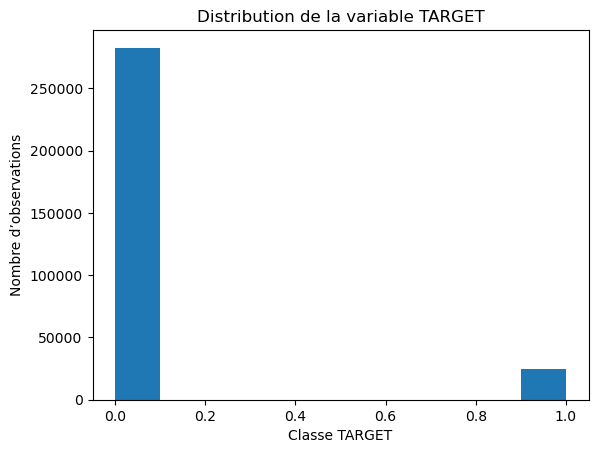

In [38]:
# Aperçu graphique de la distribution de la variable 
df['TARGET'].plot.hist()

plt.title('Distribution de la variable TARGET')
plt.xlabel('Classe TARGET')
plt.ylabel('Nombre d’observations')

**Remarque :**  
- 7% du jeu de donnée représente des prêts non remboursés. Et heureusement!  
- 13.7% de jeu de donnée sont des NaN, liés aux données ajoutées qui ne possédaient par la colonne TARGET


Dans le cadre de notre mission, cela implique un **déséquilibre important entre les classes**, il s'agit d'une **information qu'il sera nécessaire d'ajuster lors de l'utilisation de modèle ML**.

In [39]:
# Aperçu des données manquantes
missing_values_train = tabvaleurs_manquantes(df_train)
missing_values_train

Votre dataframe a 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


**Remarque :** Notre jeu de données contient 67 colonnes avec des données manquantes dont certaines avec un grand nombre ( + de 50% ). Il conviendra de réfléchir à un traitement adapter de ces données .  

Pour le moment, nous n'avons pas assez d'informations pour savoir quelle méthode choisir pour traiter les valeurs manquantes. Nous ne pouvons prendre le risque de supprimer des colonnes qui vont être utiles pour la modélisation. 

In [40]:
# Aperçu des différents types de données

df.dtypes.value_counts()

float64    105
object      16
int64        1
dtype: int64

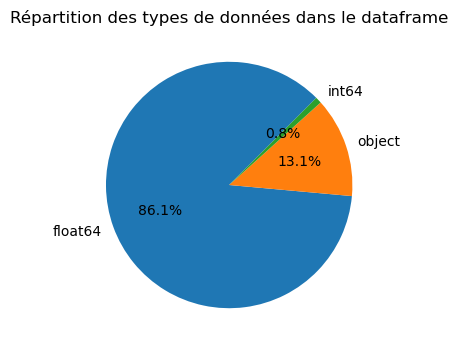

In [41]:
# Aperçu graphique pie des types de données
type_counts = df.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [42]:
# Nombre de classe unique pour chaque données 'object'
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Remarque :** Les données incluent une variété de classe unique dans les variables catégorielles, une majorité avec  un petit nombre, comme par exemple, NAME_CONTRACT_TYPE, et d'autres avec un nombre plus élevé, comme ORGANIZATION_TYPE.  

Cette diversité nécessite une attention particulière dans le choix des techniques d'encodages.


In [43]:
# Recherche de présences de doublons par l'identifiant
df['SK_ID_CURR'].duplicated().sum()

0

In [44]:
# Aperçu des statistiques descriptives des données catégorielles
df.describe(exclude = np.number)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,356255,356255,356255,356255,354052,356255,356255,356255,356255,244259,356255,356255,113163,178339,176021,188291
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,326537,235126,235235,246970,288253,183307,252379,228715,316513,63841,63652,78832,85954,175162,77309,185607


In [45]:
# Aperçu des statistiques descriptives
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,307511.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356253.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,162345.000000,3.555870e+05,286622.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,185200.000000,355205.000000,355205.000000,355205.000000,355205.000000,356254.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.080729,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,-4983.593527,-3002.071163,12.023741,0.999994,0.818498,0.200098,0.998170,0.278612,0.071213,2.151858,2.050506,2.028932,12.055749,0.015649,0.051371,0.040847,0.078076,0.229661,0.178824,0.501965,5.148900e-01,0.509350,0.118138,0.088673,0.977889,0.752283,0.045045,0.079819,0.150015,0.227331,0.232817,0.066454,0.101495,0.108089,0.008868,0.028503,0.114914,0.087750,0.977239,0.759452,0.042930,0.075346,0.145471,0.223315,0.228878,0.065092,0.106382,0.106641,0.008116,0.027183,0.118549

## Nettoyage des données catégorielles

In [46]:
# Répartition de la feature "genre"
df['CODE_GENDER'].value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

In [47]:
df = df[df['CODE_GENDER'] != 'XNA']

**Remarque :** Présence d'un genre inadapté, avec peu d'occurence. Nous décidons de supprimer ces valeurs considérées comme outliers.

In [48]:
# Répartition de la feature "Type de revenus"
df['NAME_INCOME_TYPE'].value_counts()

Working                 183304
Commercial associate     83018
Pensioner                64635
State servant            25235
Unemployed                  23
Student                     20
Businessman                 11
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [49]:
df = df[df['NAME_INCOME_TYPE'] != 'Maternity leave']

**Remarque :** Suppression du terme congé maternité, propos discriminatoire et peu informatif sur la situation client + peu de lignes concernées.

In [50]:
# Répartition de la feature "Statut familial"
df['NAME_FAMILY_STATUS'].value_counts()

Married                 228707
Single / not married     52480
Civil marriage           34035
Separated                22725
Widow                    18297
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [51]:
df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']

**Remarque :** Elimination des 2 occurences où la situation familiale est inconnue. 

In [52]:
# Répartition de la feature "Type de logement"
df['NAME_HOUSING_TYPE'].value_counts()

House / apartment      316504
With parents            17074
Municipal apartment     12798
Rented apartment         5599
Office apartment         3024
Co-op apartment          1245
Name: NAME_HOUSING_TYPE, dtype: int64

In [53]:
df.loc[df['NAME_HOUSING_TYPE'] == 'House / apartment'].head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765.0,-1188.0,-1186.0,-291.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,2.0,1.0,1.0,MONDAY,11.0,0.0,0.0,0.0,0.0,0.0,0.0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.0,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,1.0,

In [54]:
df.loc[df['NAME_HOUSING_TYPE'] != 'With parents', 'NAME_HOUSING_TYPE'] = 'House / apartment'

**Remarque :** Après avoir observer les différents types de logements, nous avons décidé de regrouper les logements en 2 catégories : Maison / Appartement ou logé(e) chez les parents. 

In [55]:
# Répartition de la feature "Type d'organisation"
df['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    78832
XNA                       64648
Self-employed             44331
Other                     19390
Medicine                  12908
Business Entity Type 2    12031
Government                11912
School                    10180
Trade: type 7              9134
Kindergarten               7917
Construction               7760
Business Entity Type 1     6869
Transport: type 4          6282
Trade: type 3              4070
Industry: type 9           3867
Industry: type 3           3766
Security                   3719
Housing                    3393
Military                   3164
Industry: type 11          3120
Bank                       2880
Police                     2781
Agriculture                2746
Transport: type 2          2651
Postal                     2451
Security Ministries        2315
Trade: type 2              2142
Restaurant                 2095
Services                   1877
University                 1548
Industry: type 7           1524
Transpor

**Remarque :** Regroupement des organisations sans les 'types' pour plus de simplicité et transformation des 'XNA' en NaN car peu informatif ou erroné.

In [56]:
group_mapping = {
    'Business Entity Type 3' : 'Business Entity',
    'Business Entity Type 2' : 'Business Entity',
    'Business Entity Type 1' : 'Business Entity',
    
    'Trade: type 7' : 'Trade',
    'Trade: type 3' : 'Trade',
    'Trade: type 2' : 'Trade',
    'Trade: type 6' : 'Trade',
    'Trade: type 1' : 'Trade',
    'Trade: type 4' : 'Trade', 
    'Trade: type 5' : 'Trade',
    
    'Transport: type 4' : 'Transport',
    'Transport: type 2' : 'Transport',
    'Transport: type 3' : 'Transport',
    'Transport: type 1' : 'Transport',
    
    'Industry: type 8' : 'Industry',
    'Industry: type 13' :  'Industry',
    'Industry: type 10' : 'Industry',
    'Industry: type 12' :  'Industry',
    'Industry: type 2' : 'Industry',
    'Industry: type 5' :  'Industry',
    'Industry: type 4' : 'Industry',
    'Industry: type 1' :  'Industry',
    'Industry: type 7' : 'Industry',
    'Industry: type 11' :  'Industry',
    'Industry: type 9' : 'Industry',
    'Industry: type 6' :  'Industry',
    'Industry: type 3' :  'Industry'
    
}

In [57]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(group_mapping)

In [58]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace('XNA', np.nan)

## Nettoyage des données numériques

In [59]:
# Statistiques descriptives du nombre d'enfants (recherche de valeurs aberrantes)
print(df['CNT_CHILDREN'].describe())

count    356244.000000
mean          0.414300
std           0.720367
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: CNT_CHILDREN, dtype: float64


(array([2.50051e+05, 7.06210e+04, 3.06940e+04, 4.25200e+03, 4.78000e+02,
        9.60000e+01, 2.40000e+01, 8.00000e+00, 5.00000e+00, 2.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

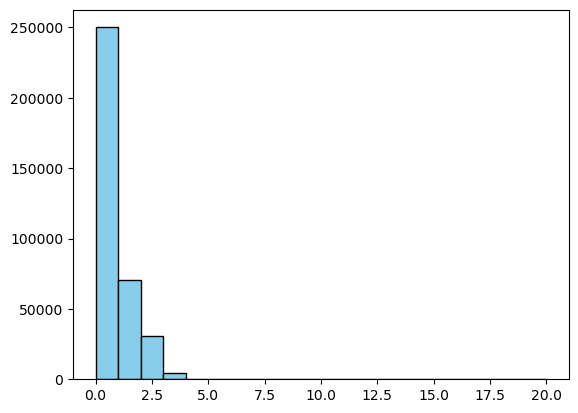

In [60]:
# Aperçu graphique
plt.hist(df['CNT_CHILDREN'], bins=20, color='skyblue', edgecolor='black')

In [61]:
df[df['CNT_CHILDREN'] > 8 ]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
23881,127782,1.0,Cash loans,F,N,N,9.0,180000.0,640080.0,31131.0,450000.0,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.006629,-10929.0,-1042.0,-950.0,-3447.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,Sales staff,10.0,2.0,2.0,THURSDAY,14.0,0.0,0.0,0.0,0.0,0.0,0.0,Self-employed,0.234368,0.470564,0.694093,0.1247,0.0000,0.9975,0.9660,NaN,0.0800,0.0690,0.3333,0.0417,0.0125,0.1017,0.0960,0.0,NaN,0.1271,0.0000,0.9975,0.9673,NaN,0.0806,0.0690,0.3333,0.0417,0.0128,0.1111,0.1000,0.0,NaN,0.1260,0.0000,0.9975,0.9665,NaN,0.08,0.0690,0.3333,0.0417,0.0128,0.1035,0.0977,0.0,NaN,reg oper account,block of flats,0.1252,Panel,No,3.0,1.0,3.0,1.0,-365.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34545,140032,1.0,Cash loans,M,Y,N,11.0,315000.0,1007761.5,38515.5,927000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-17308.0,-198.0,-3940.0,-844.0,12.0,1.0,1.0,0.0,1.0,0.0,0.0,Managers,13.0,2.0,2.0,FRIDAY,17.0,0.0,0.0,0.0,0.0,1.0,1.0,Other,0.134587,0.567454,0.122955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80948,193853,0.0,Cash loans,F,N,Y,12.0,337500.0,746280.0,59094.0,675000.0,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,0.046220,-14093.0,-2710.0,-2066.0,-3908.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,Core staff,14.0,1.0,1.0,FRIDAY,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Kindergarten,0.641817,0.703253,0.132597,0.0062,0.0164,0.9727,0.6260,0.0120,0.0000,0.0345,0.1667,0.2083,0.00

**Remarque :** On va considérer que le nombre d'enfants dans le foyer supérieurs à 8 est valeurs aberrantes.  
15 lignes sont concernées, au vue du nombre de données disponibles, nous supprimons.

In [62]:
df = df[df['CNT_CHILDREN'] <= 8]

In [63]:
# Statistiques descriptives des revenus
print(df['AMT_INCOME_TOTAL'].describe())

count    3.562290e+05
mean     1.701153e+05
std      2.235131e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.530000e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


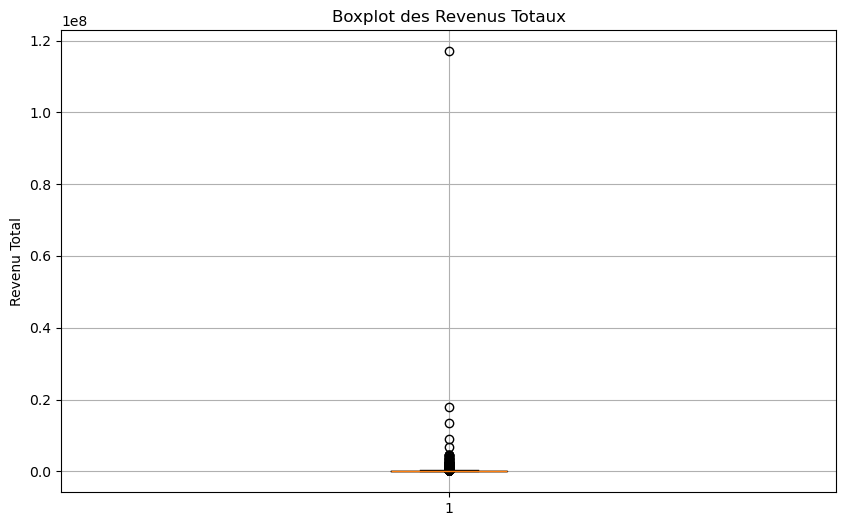

In [64]:
# Boxplot des revenus
plt.figure(figsize=(10, 6))
plt.boxplot(df['AMT_INCOME_TOTAL'])
plt.title('Boxplot des Revenus Totaux')
plt.ylabel('Revenu Total')
plt.grid(True)
plt.show()

In [65]:
# Recherche d'outliers avec la méthode IQR
income_data = df['AMT_INCOME_TOTAL']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
7         360000.0
22        450000.0
33        360000.0
49        360000.0
51        540000.0
            ...   
356193    450000.0
356195    441000.0
356196    432000.0
356202    360000.0
356225    360000.0
Name: AMT_INCOME_TOTAL, Length: 16755, dtype: float64


In [66]:
# Recherche d'outliers avec la méthode Z-score
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
1504      1080000.0
1723      1935000.0
3371      1350000.0
4603      1350000.0
5673       967500.0
            ...    
353640    1350000.0
353684    1350000.0
354312     900000.0
354725    1125000.0
355202     900000.0
Name: AMT_INCOME_TOTAL, Length: 563, dtype: float64


In [67]:
outliers_full_data = df.loc[z_score_outliers.index]
outliers_full_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1504,101769,0.0,Revolving loans,M,Y,Y,0.0,1080000.0,180000.0,9000.0,180000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.072508,-13633.0,-5536.0,-3.0,-4971.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,2.0,1.0,1.0,FRIDAY,13.0,0.0,1.0,1.0,0.0,0.0,0.0,Business Entity,NaN,0.652924,0.456110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1723,102015,0.0,Cash loans,F,N,Y,0.0,1935000.0,269550.0,10534.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.007114,-18636.0,365243.0,-3401.0,-2168.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,NaN,2.0,2.0,2.0,MONDAY,11.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.658977,0.268663,0.331251,0.0742,0.0495,0.9871,NaN,NaN,0.08,0.0690,0.3333,NaN,NaN,NaN,0.0716,NaN,NaN,0.0756,0.0514,0.9871,NaN,NaN,0.0806,0.0690,0.3333,NaN,NaN,NaN,0.0746,NaN,NaN,0.0749,0.0495,0.9871,NaN,NaN,0.08,0.0690,0.3333,NaN,NaN,NaN,0.0729,NaN,NaN,NaN,block of flats,0.0659,Panel,No,1.0,0.0,1.0,0.0,-381.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3371,103938,0.0,Cash loans,F,N,N,1.0,1350000.0,2410380.0,109053.0,2250000.0,NaN,Commercial associate,Higher education,Married,House / apartment,0.072508,-12213.0,-843.0,-757.0,-4132.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Managers,3.0,1.0,1.0,SUNDAY,13.0,0.0,1.0,1.0,0.0,0.0,0.0,Housing,NaN,0.724541,0.569149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**Remarque :** Sur 2 calculs des outliers, on peut constater des très hauts revenus qui se démarquent, cependant, dans notre contexte, il est tout a fait légitime d'avoir moins de cients avec des revenus aussi importants pour autant les exclures enlèveraient de l'informations à notre algorithme. Il faudra rester vigilent dans le choix des modèles. 

In [68]:
# Statistiques descriptives des amortissements de crédit
print(df['AMT_CREDIT'].describe())

count    3.562290e+05
mean     5.877707e+05
std      3.986287e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.002110e+05
75%      7.975575e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64


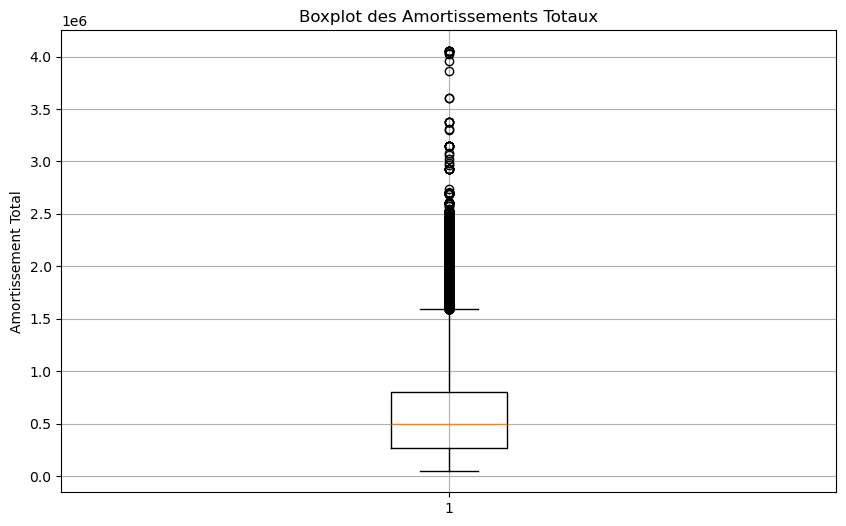

In [69]:
# Boxplot des amortissements 
plt.figure(figsize=(10, 6))
plt.boxplot(df['AMT_CREDIT'])
plt.title('Boxplot des Amortissements Totaux')
plt.ylabel('Amortissement Total')
plt.grid(True)
plt.show()

In [70]:
# Recherche d'outliers avec la méthode IQR
income_data = df['AMT_CREDIT']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
60        1663987.5
135       1755000.0
189       2250000.0
235       1710000.0
314       1800000.0
            ...    
355973    2013840.0
356066    1928304.0
356078    1800000.0
356089    1635120.0
356194    1800000.0
Name: AMT_CREDIT, Length: 7910, dtype: float64


In [71]:
# Recherche d'outliers avec la méthode Z-score
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
189       2250000.0
314       1800000.0
337       1971072.0
341       2250000.0
441       1971072.0
            ...    
355971    2013840.0
355973    2013840.0
356066    1928304.0
356078    1800000.0
356194    1800000.0
Name: AMT_CREDIT, Length: 5117, dtype: float64


In [72]:
outliers_full_data = df.loc[z_score_outliers.index]
outliers_full_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
189,100219,0.0,Cash loans,M,N,Y,1.0,315000.0,2250000.0,83515.5,2250000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.032561,-11177.0,-1514.0,-64.0,-2793.0,NaN,1.0,1.0,0.0,1.0,0.0,1.0,Core staff,3.0,1.0,1.0,FRIDAY,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity,0.380092,0.693358,NaN,0.4753,0.0694,0.9950,NaN,NaN,0.5200,0.1724,0.9583,NaN,0.1213,NaN,0.6651,NaN,0.3558,0.4842,0.0720,0.9950,NaN,NaN,0.5236,0.1724,0.9583,NaN,0.1241,NaN,0.6930,NaN,0.3767,0.4799,0.0694,0.9950,NaN,NaN,0.52,0.1724,0.9583,NaN,0.1234,NaN,0.6771,NaN,0.3633,NaN,block of flats,0.6216,Monolithic,No,0.0,0.0,0.0,0.0,-926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
314,100361,0.0,Cash loans,M,N,Y,0.0,270000.0,1800000.0,62698.5,1800000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007274,-17099.0,-499.0,-5508.0,-649.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,Laborers,2.0,2.0,2.0,TUESDAY,11.0,0.0,0.0,0.0,0.0,0.0,0.0,Trade,0.404589,0.433919,0.786267,0.0680,0.0836,0.9896,0.8572,0.0178,0.0000,0.1724,0.1667,0.0417,NaN,0.0555,0.0878,0.0000,0.0000,0.0693,0.0868,0.9896,0.8628,0.0179,0.0000,0.1724,0.1667,0.0417,NaN,0.0606,0.0915,0.0000,0.0000,0.0687,0.0836,0.9896,0.8591,0.0179,0.00,0.1724,0.1667,0.0417,NaN,0.0564,0.0894,0.0000,0.0000,reg oper account,block of flats,0.0690,Panel,No,0.0,0.0,0.0,0.0,-991.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
337,100389,0.0,Cash loans,M,Y,Y,0.0,247500.0,1971072.0,68643.0,1800000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.006207,-14216.0,-365.0,-3183.0,-4423.0,13.0,1.0,1.0,1.0,1.0,0.0,0.0,Core staff,2.0,2.0,2.0,WEDNESDAY,14.0,0.0,0.0,0.0,0.0,0.0,0.0,Self-employed,0.558582,0.74820

**Remarque :** Nous considérons les données ci-dessus comme atypiques et non aberrantes. 

In [73]:
# Statistiques descriptives des anuuités
print(df['AMT_ANNUITY'].describe())

count    356193.000000
mean      27425.516335
std       14732.644298
min        1615.500000
25%       16731.000000
50%       25078.500000
75%       34960.500000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64


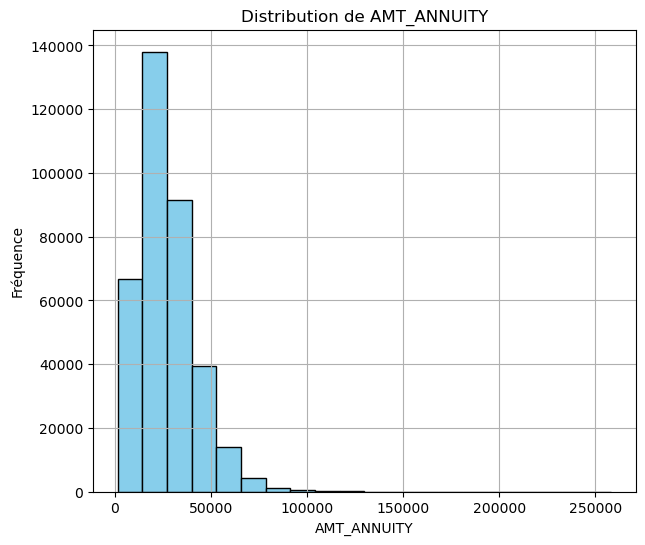

In [74]:
# Aperçu graphique
plt.figure(figsize=(7, 6))
plt.hist(df['AMT_ANNUITY'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution de AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [75]:
# Recherche d'outliers avec la méthode IQR
income_data = df['AMT_ANNUITY']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
60        86989.5
94        64107.0
112       73611.0
189       83515.5
191       77494.5
           ...   
356066    79578.0
356078    62568.0
356172    66978.0
356194    74286.0
356222    65313.0
Name: AMT_ANNUITY, Length: 8863, dtype: float64


In [76]:
# Recherche d'outliers avec la méthode Z-Score
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
60         86989.5
112        73611.0
189        83515.5
191        77494.5
485       116266.5
            ...   
355906     72607.5
355972     72621.0
355998     98113.5
356066     79578.0
356194     74286.0
Name: AMT_ANNUITY, Length: 3480, dtype: float64


In [77]:
# Filtre des lignes où le revenu total est inférieur à l'annuité
filtered_data = df[df['AMT_INCOME_TOTAL'] < df['AMT_ANNUITY']]
filtered_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
678,100784,1.0,Cash loans,F,N,Y,0.0,54000.0,1885500.0,74191.5,1885500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.031329,-22181.0,365243.0,-14266.0,-4714.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,NaN,2.0,2.0,2.0,MONDAY,10.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.623843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0066,NaN,No,6.0,0.0,6.0,0.0,-1683.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20727,124157,1.0,Cash loans,F,Y,Y,0.0,25650.0,2173500.0,48118.5,2173500.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.035792,-21517.0,365243.0,-1669.0,-4962.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,2.0,2.0,2.0,MONDAY,14.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.498675,0.175965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,0.0,-677.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25802,129999,0.0,Cash loans,F,N,Y,0.0,46044.0,1024740.0,52452.0,900000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.002134,-20148.0,365243.0,-4362.0,-2417.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0,NaN,2.0,3.0,3.0,WEDNESDAY,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.479272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

**Remarque :** Après avoir observer les résultats du Z-Score, nous avons effectué une recherche manuelle pour filtrer les annuités supérieurs aux revenus totaux qui semblent être des valeurs aberrantes car extrêmement risqué dans le cadre d'un financement à la consommation.

In [78]:
indexes_to_drop = filtered_data.index
df.drop(indexes_to_drop, inplace=True)

In [79]:
# Statistiques descriptives des prix de biens ( achetés avec le financement)
df['AMT_GOODS_PRICE'].describe()

count    3.559100e+05
mean     5.279703e+05
std      3.660224e+05
min      4.050000e+04
25%      2.340000e+05
50%      4.500000e+05
75%      6.750000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

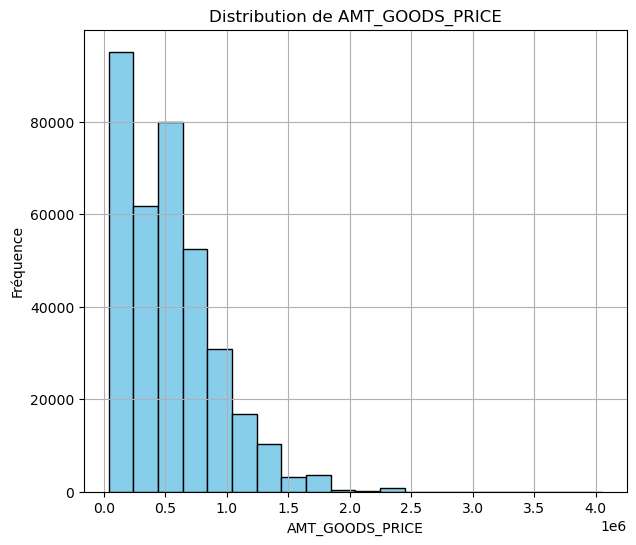

In [80]:
# Aperçu graphique 
plt.figure(figsize=(7, 6))
plt.hist(df['AMT_GOODS_PRICE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution de AMT_GOODS_PRICE')
plt.xlabel('AMT_GOODS_PRICE')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [81]:
# Recherche d'outliers avec la méthode IQR
income_data = df['AMT_GOODS_PRICE']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
6         1395000.0
7         1530000.0
48        1350000.0
49        1350000.0
60        1588500.0
            ...    
356078    1800000.0
356089    1350000.0
356156    1350000.0
356183    1350000.0
356194    1800000.0
Name: AMT_GOODS_PRICE, Length: 16776, dtype: float64


In [82]:
# Recherche d'outliers avec la méthode Z-score
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
135       1755000.0
189       2250000.0
235       1710000.0
314       1800000.0
337       1800000.0
            ...    
355971    1800000.0
355973    1800000.0
356066    1800000.0
356078    1800000.0
356194    1800000.0
Name: AMT_GOODS_PRICE, Length: 5138, dtype: float64


**Remarque :** Le client peut tout a fait effectuer un crédit d'un partie du montant du bien acheté. Les montants ont l'air de suivre la même proportion que les montants de financement. Valeurs attypiques et non, aberrantes. 

In [83]:
# Statistiques descriptives des âges
(df['DAYS_BIRTH'] / -365).describe()

count    356186.000000
mean         43.948250
std          11.941752
min          20.104110
25%          34.041096
50%          43.164384
75%          53.904110
max          69.120548
Name: DAYS_BIRTH, dtype: float64

**Remarque :** L'âge des clients est cohérente. 

In [84]:
(df['DAYS_EMPLOYED'] / -365).describe()

count    356186.000000
mean       -176.176248
std         388.205202
min       -1000.665753
25%           0.794521
50%           3.353425
75%           7.619178
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [85]:
df[df['DAYS_EMPLOYED'] == 365243 ]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
8,100011,0.0,Cash loans,F,N,Y,0.0,112500.000,1019610.0,33826.5,913500.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099.0,365243.0,-7427.0,-3514.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,NaN,2.0,2.0,2.0,WEDNESDAY,14.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.587334,0.205747,0.751724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,100015,0.0,Cash loans,F,N,Y,0.0,38419.155,148365.0,10678.5,135000.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.015221,-20417.0,365243.0,-5246.0,-2512.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,NaN,2.0,2.0,2.0,FRIDAY,7.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.722044,0.555183,0.652897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2396.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
23,100027,0.0,Cash loans,F,N,Y,0.0,83250.000,239850.0,23850.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.006296,-24827.0,365243.0,-9012.0,-3684.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,NaN,2.0,3.0,3.0,FRIDAY,12.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.624305,0.669057,0.1443,0.0848,0.9876,0.8300,0.1064,0.1400,0.1207,0.3750,0.4167,0.2371,0.1173,0.1484,0.0019,0.0007,0.1261,0.0754,0.9876,0.8367,0.0000,0.1208,0.1034,0.3750,0.4167,0.2425,0.1102,0.0923,0.0000,0.0000,0.1457,0.0848,0.9876,0.8323,0.1071,0.14,0.1207,0.3750,0.4167,0.2412,0.1



**Remarque :**   
365243 jours / 365,25 jours/an ≈ 1000,27 années  

Au vue du nombre de lignes concernée, nous remplaçons ces valeurs aberrantes par NaN pour future imputation.  

In [86]:
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

In [87]:
# Statistiques descriptibes de l'âge du véhicule
df['OWN_CAR_AGE'].describe()

count    120995.000000
mean         12.023579
std          11.880684
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

In [88]:
# Recherche d'outliers avec la méthode IQR
income_data = df['OWN_CAR_AGE']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
85        65.0
134       65.0
237       64.0
272       65.0
369       64.0
          ... 
355645    31.0
355881    65.0
355964    36.0
356099    34.0
356249    65.0
Name: OWN_CAR_AGE, Length: 5608, dtype: float64


In [89]:
# Recherche d'outliers avec la méthode Z-score
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
85        65.0
134       65.0
237       64.0
272       65.0
369       64.0
          ... 
355501    65.0
355522    65.0
355534    65.0
355881    65.0
356249    65.0
Name: OWN_CAR_AGE, Length: 3833, dtype: float64


In [90]:
df[df['OWN_CAR_AGE'] >= 70 ]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
271741,415025,1.0,Cash loans,M,Y,Y,1.0,180000.0,675000.0,34465.5,675000.0,Unaccompanied,Working,Secondary / secondary special,Married,With parents,0.018209,-9894.0,-1320.0,-4675.0,-2559.0,91.0,1.0,1.0,1.0,1.0,1.0,0.0,Drivers,3.0,3.0,3.0,TUESDAY,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity,NaN,0.523138,0.133429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-688.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
294131,440757,0.0,Revolving loans,M,Y,N,1.0,112500.0,180000.0,9000.0,180000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.018850,-11195.0,-897.0,-3582.0,-3691.0,91.0,1.0,1.0,0.0,1.0,0.0,0.0,Drivers,3.0,2.0,2.0,WEDNESDAY,14.0,0.0,0.0,0.0,0.0,0.0,0.0,Industry,NaN,0.686340,0.794629,0.0124,0.025,0.9717,0.6124,NaN,0.0,0.069,0.0417,NaN,0.0107,0.0092,0.0104,0.0039,0.0241,0.0084,0.0201,0.9697,0.6014,NaN,0.0,0.069,0.0417,NaN,0.0106,0.0055,0.0079,0.0,0.0208,0.0125,0.025,0.9717,0.6176,NaN,0.0,0.069,0.0417,NaN,0.0109,0.0094,0.0105,0.0039,0.0246,NaN,block of flats,0.0173,"Stone, brick",No,19.0,0.0,19.0,0.0,-2352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
321542,201386,NaN,Cash loans,M,Y,N,0.0,90000.0,260640.0,26838.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.020246,-24473.0,NaN,-8046.0,-4288.0,74.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,2.0,3.0,3.0,FRIDAY,8.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.048800,0.740799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**Remarque :** Nous considérons l'âge de ces véhicules comme attypiques et non aberrants ( Quid des véhicules de collection)

# Jeux de données bureau|bureau_balance

Nous poursuivons avec l'analyse des dataframes bureau|bureau_balance

In [91]:
# Dimension de df_bureau
df_bureau.shape

(1716428, 17)

In [92]:
# Aperçu des premières lignes
df_bureau.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [93]:
# Recherche de doublon par l'identifiant
df_bureau['SK_ID_BUREAU'].duplicated().sum()

0

Le dataframe df_bureau contient 1,716,428 lignes et 17 colonnes, détaillant les crédits antérieurs des clients.  

Les données incluent des informations sur le statut du crédit, les montants, et l'historique des paiements. Des valeurs manquantes et potentielles valeurs aberrantes nécessitent un traitement avant toute analyse approfondie.

In [94]:
# Dimention de df_bureau_balance
df_bureau_balance.shape

(27299925, 3)

In [95]:
# Aperçu des premières lignes
df_bureau_balance.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [96]:
# Recherche de doublon par l'identifiant bureau
df_bureau_balance['SK_ID_BUREAU'].duplicated().sum()

26482530

Le dataframe df_bureau_balance comprend 27,299,925 enregistrements et 3 colonnes, relatifs à l'historique mensuel des statuts de crédit par crédit. La majorité des enregistrements sont des duplicatas pour SK_ID_BUREAU, indiquant plusieurs entrées par crédit. Les données montrent l'évolution du statut de crédit (par exemple, "C" pour clôturé, "0" pour sans retard) sur différents mois (MONTHS_BALANCE). Un nettoyage pour gérer les duplicatas et une analyse des séquences de statuts seront nécessaires pour interpréter correctement l'historique de crédit.

In [97]:
# Aggregation des données par rapport à SK_ID_BUREAU ( énormément de doublons)

feature_cat = ['STATUS']

agg_bureau_balance = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in feature_cat:
    agg_bureau_balance[col] = [lambda x: x.mode()[0] if not x.mode().empty else np.nan]
    
    
agg_bb = df_bureau_balance.groupby('SK_ID_BUREAU').agg(agg_bureau_balance)
agg_bb.columns = pd.Index([e[0] + "_" + e[1].upper() for e in agg_bb.columns.tolist()])

In [98]:
agg_bb.head(10)

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_<LAMBDA>
SK_ID_BUREAU,,,,
5001709,-96,0,97,C
5001710,-82,0,83,C
5001711,-3,0,4,0
5001712,-18,0,19,0
5001713,-21,0,22,X
5001714,-14,0,15,X
5001715,-59,0,60,X
5001716,-85,0,86,C
5001717,-21,0,22,0


In [99]:
# Fusion des données de bureau avec les agrégats de bureau_balance

df_b = pd.merge(df_bureau, agg_bb, on='SK_ID_BUREAU', how='left')

In [100]:
df_b

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_<LAMBDA>
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN,NaN,NaN,NaN,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN,NaN,NaN,NaN,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN,NaN,NaN,NaN,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN,NaN,NaN,NaN,NaN


## Analyse Exploratoire

In [101]:
# Informations conscises sur le df fusionné
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
 17  MONTHS_BALANCE_MIN      float64
 18  MONTHS_BALANCE_MAX      float64
 19  MONTHS_BALANCE_SIZE     float64
 20  STATUS_<LAMBDA>         object 
dtypes: float64(11), int64(6), objec

In [102]:
# Aperçu des valeurs manquantes
missing_values_bureau = tabvaleurs_manquantes(df_b)
missing_values_bureau

Votre dataframe a 21 colonnes.
Il y a 11 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
MONTHS_BALANCE_MIN,942074,54.9
MONTHS_BALANCE_MAX,942074,54.9
MONTHS_BALANCE_SIZE,942074,54.9
STATUS_<LAMBDA>,942074,54.9
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1


**Remarque :** Le dataset combiné montre des valeurs manquantes dans presque toutes les colonnes, nécessitant un traitement préalable pour des analyses fiables.

In [103]:
# Aperçu des différents types de données

df_b.dtypes.value_counts()

float64    11
int64       6
object      4
dtype: int64

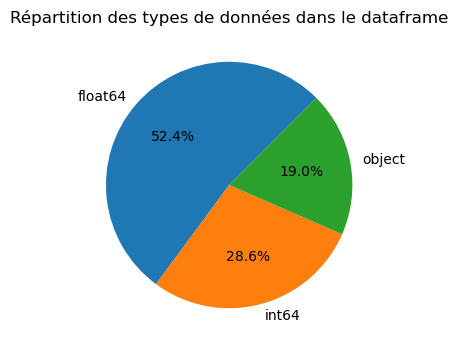

In [104]:
# Graphique pie des types de données
type_counts = df_b.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [105]:
# Nombre de classe unique pour chaque données 'object'
df_b.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
STATUS_<LAMBDA>     8
dtype: int64

In [106]:
# Statistiques descriptives données catégorielles
df_b.describe(exclude = np.number)

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS_<LAMBDA>
count,1716428,1716428,1716428,774354
unique,4,4,15,8
top,Closed,currency 1,Consumer credit,C
freq,1079273,1715020,1251615,321876


In [107]:
# Statistiques descriptives
df_b.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05,774354.000000,774354.000000,774354.000000
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04,-36.288669,-6.062975,31.225694
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05,25.449736,15.064299,23.483837
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00,-96.000000,-95.000000,1.000000
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00,-53.000000,0.000000,12.000000
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00,-31.000000,0.000000,25.000000
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04,-15.000000,0.000000,45.000000
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08,0.000000,0.000000,97.000000


## Nettoyage des données catégorielles

In [108]:
# Répartitions des états des crédits actifs
df_b['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [109]:
df_b['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [110]:
df_b['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

**Remarque :** Pour simplifier l'analyse et améliorer la compréhension des différents types de crédits présents dans notre dataset, nous allons procéder à un regroupement des prêts en catégories plus larges. 

In [111]:
df_b['CREDIT_TYPE'] =df_b['CREDIT_TYPE'].apply(group_credit_type)

In [112]:
df_b['CREDIT_TYPE'].value_counts()

Consumer loans       1291774
Revolving credit      402195
Mortgage loans         18418
Business loans          2463
Other loans             1572
Specialized loans          6
Name: CREDIT_TYPE, dtype: int64

In [113]:
df_b['STATUS_<LAMBDA>'].value_counts()

C    321876
0    310731
X    139098
1      1556
5      1064
2        26
3         2
4         1
Name: STATUS_<LAMBDA>, dtype: int64

## Nettoyage des données numériques

In [114]:
df_b['DAYS_CREDIT'].describe()

count    1.716428e+06
mean    -1.142108e+03
std      7.951649e+02
min     -2.922000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max      0.000000e+00
Name: DAYS_CREDIT, dtype: float64

(array([ 47137.,  51695.,  56894.,  53955.,  49900.,  35938.,  40812.,
         54562.,  66378.,  80971.,  89889.,  97227., 106785., 107929.,
        118204., 127570., 134756., 147090., 144486., 104250.]),
 array([-2922. , -2775.9, -2629.8, -2483.7, -2337.6, -2191.5, -2045.4,
        -1899.3, -1753.2, -1607.1, -1461. , -1314.9, -1168.8, -1022.7,
         -876.6,  -730.5,  -584.4,  -438.3,  -292.2,  -146.1,     0. ]),
 <BarContainer object of 20 artists>)

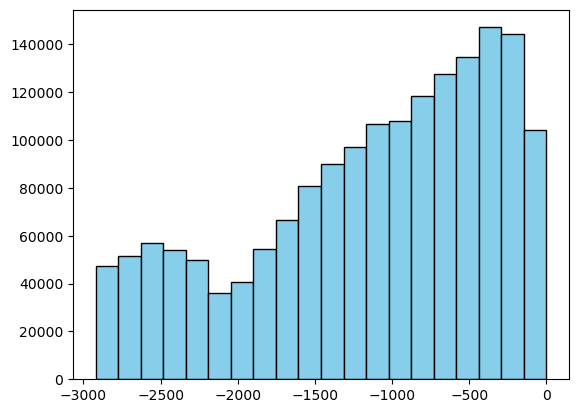

In [115]:
plt.hist(df_b['DAYS_CREDIT'], bins=20, color='skyblue', edgecolor='black')

In [116]:
df_b['CREDIT_DAY_OVERDUE'].describe()

count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64

In [117]:
df_b[df_b['CREDIT_DAY_OVERDUE']>0]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_<LAMBDA>
365,282297,5714943,Active,currency 1,-2712,2603,-2498.0,NaN,4590.0,0,24696.000,231.525,0.0,231.525,Consumer loans,-1077,NaN,NaN,NaN,NaN,NaN
785,408647,5715468,Active,currency 1,-313,6,233.0,NaN,NaN,0,417208.500,214947.000,0.0,288.000,Consumer loans,-5,NaN,NaN,NaN,NaN,NaN
936,380677,5715645,Active,currency 1,-2659,30,-2353.0,NaN,NaN,0,57024.000,0.000,NaN,58.500,Consumer loans,-493,NaN,NaN,NaN,NaN,NaN
1575,218135,5716400,Active,currency 1,-2543,2156,-2172.0,NaN,NaN,0,45000.000,NaN,NaN,504.000,Consumer loans,-2156,NaN,NaN,NaN,NaN,NaN
1791,229323,5716671,Active,currency 1,-757,496,NaN,NaN,NaN,0,225000.000,NaN,NaN,169582.500,Consumer loans,-4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707319,226956,5027625,Active,currency 1,-52,19,224.0,NaN,2151.0,0,23701.500,18819.000,0.0,22.500,Consumer loans,-18,NaN,NaN,NaN,NaN,NaN
1707833,108883,5028638,Active,currency 1,-907,20,553.0,NaN,NaN,0,135000.000,137119.500,NaN,193.500,Revolving credit,-13,0.0,-29.0,0.0,30.0,0
1709570,141935,5582069,Active,currency 1,-80,20,1016.0,NaN,22.5,0,166137.255,160812.000,0.0,22.500,Consumer loans,-11,NaN,NaN,NaN,NaN,NaN
1709789,385777,5582323,Active,currency 1,-126,24,606.0,NaN,NaN,0,405000.000,362002.500,0.0,22.500,Consumer loans,-9,NaN,NaN,NaN,NaN,NaN


In [118]:
df_b['DAYS_CREDIT_ENDDATE'].describe()

count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64

(array([1.340000e+02, 0.000000e+00, 0.000000e+00, 1.200000e+01,
        0.000000e+00, 1.524343e+06, 2.833000e+04, 1.957400e+04,
        2.800000e+01, 3.845400e+04]),
 array([-42060. , -34734.1, -27408.2, -20082.3, -12756.4,  -5430.5,
          1895.4,   9221.3,  16547.2,  23873.1,  31199. ]),
 <BarContainer object of 10 artists>)

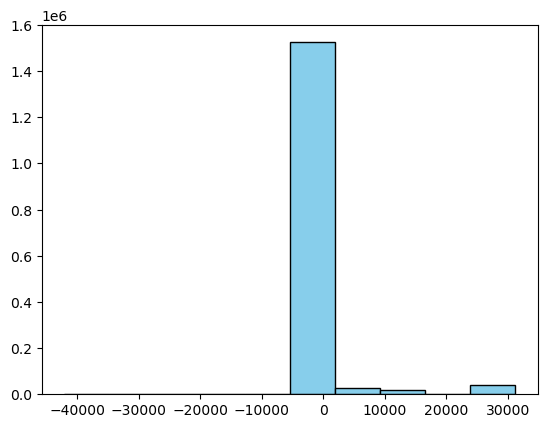

In [119]:
plt.hist(df_b['DAYS_CREDIT_ENDDATE'], bins=10, color='skyblue', edgecolor='black')

In [120]:
income_data = df_b['DAYS_CREDIT_ENDDATE']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
5          27460.0
12          5261.0
53         10285.0
99          9341.0
141        31111.0
            ...   
1716322    31092.0
1716359    31090.0
1716379    31129.0
1716417    31128.0
1716422    31129.0
Name: DAYS_CREDIT_ENDDATE, Length: 79340, dtype: float64


In [121]:
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
5          27460.0
141        31111.0
180        27460.0
241        31081.0
393        27460.0
            ...   
1716322    31092.0
1716359    31090.0
1716379    31129.0
1716417    31128.0
1716422    31129.0
Name: DAYS_CREDIT_ENDDATE, Length: 38630, dtype: float64


In [122]:
df_b[(df_b['DAYS_CREDIT_ENDDATE'] > 14600) & (df_b['CREDIT_ACTIVE'] == 'Active') & (df_b['CREDIT_TYPE'] != 'Revolving credit')]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_<LAMBDA>
898,190334,5715603,Active,currency 1,-1218,0,30956.0,NaN,NaN,0,216000.000,15457.50,0.0,0.0,Consumer loans,-495,NaN,-40.0,-28.0,13.0,X
7491,107302,5723505,Active,currency 1,-553,0,31061.0,NaN,NaN,0,45000.000,0.00,0.0,0.0,Consumer loans,-397,NaN,NaN,NaN,NaN,NaN
14555,260886,6024013,Active,currency 1,-1252,0,30876.0,NaN,NaN,0,72000.000,3802.50,0.0,0.0,Consumer loans,-575,0.000,-41.0,0.0,42.0,C
18203,387209,5192048,Active,currency 1,-1104,0,31039.0,NaN,NaN,0,391500.000,0.00,0.0,0.0,Consumer loans,-435,NaN,NaN,NaN,NaN,NaN
23629,354052,5198586,Active,currency 1,-1099,0,31024.0,NaN,NaN,0,126000.000,4.50,0.0,0.0,Consumer loans,-427,NaN,NaN,NaN,NaN,NaN
52451,157510,5229427,Active,currency 1,-1415,0,30753.0,NaN,NaN,0,108000.000,9391.50,0.0,0.0,Consumer loans,-698,0.000,-46.0,0.0,47.0,0
54989,398089,5232360,Active,currency 1,-1103,0,31019.0,NaN,NaN,0,63000.000,0.00,0.0,0.0,Consumer loans,-432,NaN,NaN,NaN,NaN,NaN
57100,427200,5235034,Active,currency 1,-396,0,31078.0,NaN,NaN,0,45000.000,0.00,0.0,0.0,Consumer loans,-395,NaN,NaN,NaN,NaN,NaN
75142,448891,5252875,Active,currency 1,-542,0,31017.0,NaN,NaN,0,45000.000,0.00,0.0,0.0,Consumer loans,-449,4500.000,-17.0,-15.0,3.0,X
85277,105602,5729931,Active,currency 1,-1204,0,30987.0,NaN,NaN,0,270000.000,0.00,0.0,0.0,Consumer loans,-472,0.000,-39.0,0.0,40.0,0


**Remarque :** Les conditions réunies dans l'aperçu ci-dessus montre les données aberrantes en rapport avec les connaissances métiers.  

Nous avons : 
- Pris une durée de 40 ans ( extremement rare )
- Vérifier si le crédit était encore actif
- Seuls les crédits renouvelables ne bénéficient pas réellement de délai de remboursement selon l'utilisation du client.

In [123]:
# Conditions pour filtrer le DataFrame
conditions = (
    (df_b['DAYS_CREDIT_ENDDATE'] > 14600) &
    (df_b['CREDIT_ACTIVE'] == 'Active') &
    (df_b['CREDIT_TYPE'] != 'Revolving credit')
)

# Remplacez les valeurs par NaN où les conditions sont remplies
df_b.loc[conditions, 'DAYS_CREDIT_ENDDATE'] = np.nan

In [124]:
print(df_b['DAYS_ENDDATE_FACT'].describe())

count    1.082775e+06
mean    -1.017437e+03
std      7.140106e+02
min     -4.202300e+04
25%     -1.489000e+03
50%     -8.970000e+02
75%     -4.250000e+02
max      0.000000e+00
Name: DAYS_ENDDATE_FACT, dtype: float64


In [125]:
income_data = df_b['DAYS_ENDDATE_FACT']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
198346   -42023.0
Name: DAYS_ENDDATE_FACT, dtype: float64


In [126]:
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
198346   -42023.0
Name: DAYS_ENDDATE_FACT, dtype: float64


**Remarque :** Notre fonction Outliers Z Score a détecté les valeurs extremes, toutes correspondantes au chiffre - 42023 qui représente environ 115 ans. Nous décidons de les remplacer par des NaN.

In [127]:
df_b['DAYS_ENDDATE_FACT'].replace(-42023.0, np.nan, inplace=True)

In [128]:
df_b['AMT_CREDIT_MAX_OVERDUE'].describe()

count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

**Remarque :** La colonne AMT_CREDIT_MAX_OVERDUE dispose de plus de 75 % de données manquantes, c'est une colonne qui sera certainement supprimée au vue du nombre important d'absence de valeurs.

In [129]:
df_b['AMT_CREDIT_SUM'].describe()

count    1.716415e+06
mean     3.549946e+05
std      1.149811e+06
min      0.000000e+00
25%      5.130000e+04
50%      1.255185e+05
75%      3.150000e+05
max      5.850000e+08
Name: AMT_CREDIT_SUM, dtype: float64

In [130]:
income_data = df_b['AMT_CREDIT_SUM']

iqr_outliers = outliers_iqr(income_data)
print("Outliers detected by IQR:")
print(iqr_outliers)

Outliers detected by IQR:
4          2700000.00
12         7033500.00
23         1350000.00
26         3709552.50
47         1058823.54
              ...    
1716330    1575000.00
1716389     721863.00
1716396    1057500.00
1716399     972000.00
1716403    1431000.00
Name: AMT_CREDIT_SUM, Length: 187998, dtype: float64


In [131]:
z_score_outliers = outliers_z_score(income_data)
print("Outliers detected by Z-Score:")
print(z_score_outliers)

Outliers detected by Z-Score:
12         7033500.0
343        7794000.0
384        5355000.0
406        3996000.0
417        5850000.0
             ...    
1715800    6300000.0
1715877    8262000.0
1715986    5395500.0
1716173    9720000.0
1716221    4081248.0
Name: AMT_CREDIT_SUM, Length: 16756, dtype: float64


**Remarque :** Les valeurs sont très élevées par rapport aux données statistiques mais semblent plutôt atypique si on prend en compte le point de vue métier en plus de celui statistique.  

En effet, la disparité au niveau des revenus des clients peut expliquer les écarts importants en terme de montant de financement.

# Jeu de données previous_application

In [132]:
df_previous.shape

(1670214, 37)

In [133]:
df_previous.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df_previous['SK_ID_PREV'].duplicated().sum()

0

In [135]:
df_previous['SK_ID_CURR'].duplicated().sum()

1331357

## Analyse exploratoire

In [136]:
df_previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [137]:
# Aperçu des données manquantes

missing_values_previous= tabvaleurs_manquantes(df_previous)
missing_values_previous

Votre dataframe a 37 colonnes.
Il y a 16 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


In [138]:
# Aperçu des différents types de données

df_previous.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

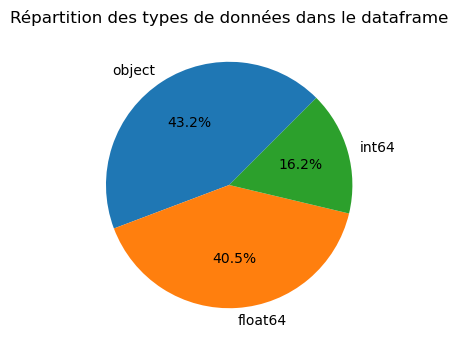

In [139]:
type_counts = df_previous.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [140]:
df_previous.describe(exclude = np.number)

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


In [141]:
df_previous.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


## Nettoyage des données catégorielles

In [142]:
df_previous['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

**Remarque :** Au vue du nombre de données à notre disposition, nous décidons de supprimer les XNA.

In [143]:
df_previous = df_previous[df_previous['NAME_CONTRACT_TYPE'] != 'XNA']

In [144]:
df_previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316004
Refused          290647
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [145]:
df_previous['NAME_CLIENT_TYPE'].value_counts()

Repeater     1230960
New           301342
Refreshed     135625
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

**Remarque :** Idem que pour les types de contrats, on supprime les valeurs XNA.

In [146]:
df_previous = df_previous[df_previous['NAME_CLIENT_TYPE'] != 'XNA']

## Nettoyage des données numériques

**Remarque :** On a pu constater dans les données statistiques la présence de 365 243 comme précédemments qui est une valeur aberrante que nous allons éliminer de nos données. 

In [147]:
df_previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
df_previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
df_previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
df_previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
df_previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Jeux de données POS_CASH_balance

In [148]:
df_pos_cash.shape

(10001358, 8)

In [149]:
df_pos_cash.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [150]:
df_pos_cash['SK_ID_PREV'].duplicated().sum()

9065033

In [151]:
df_pos_cash['SK_ID_CURR'].duplicated().sum()

9664106

In [152]:
df_pos_cash = df_pos_cash.sort_values(by='MONTHS_BALANCE', ascending=False)

# Définition d'un dictionnaire 'aggregations' pour spécifier les opérations d'agrégation à appliquer sur chaque groupe.
# 'MONTHS_BALANCE' : extraction du maximum, de la moyenne, et du nombre d'enregistrements.
# 'SK_DPD' et 'SK_DPD_DEF' : extraction du maximum et de la moyenne des retards de paiement.
# 'NAME_CONTRACT_STATUS' : prise de la première valeur rencontrée.

aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean'],
    'NAME_CONTRACT_STATUS': 'first'
}

df_pos_cash = df_pos_cash.groupby('SK_ID_CURR').agg(aggregations)

df_pos_cash.columns = ['_'.join(col).strip() for col in df_pos_cash.columns.values]

In [153]:
df_pos_cash

,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_size,SK_DPD_max,SK_DPD_mean,SK_DPD_DEF_max,SK_DPD_DEF_mean,NAME_CONTRACT_STATUS_first
SK_ID_CURR,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,Completed
100002,-1,-10.000000,19,0,0.000000,0,0.000000,Active
100003,-18,-43.785714,28,0,0.000000,0,0.000000,Completed
100004,-24,-25.500000,4,0,0.000000,0,0.000000,Completed
100005,-15,-20.000000,11,0,0.000000,0,0.000000,Completed
...,...,...,...,...,...,...,...,...
456251,-1,-5.000000,9,0,0.000000,0,0.000000,Completed
456252,-76,-79.000000,7,0,0.000000,0,0.000000,Completed
456253,-57,-79.235294,17,5,0.294118,5,0.294118,Active


## Analyse exploratoire

In [154]:
df_pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337252 entries, 100001 to 456255
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   MONTHS_BALANCE_max          337252 non-null  int64  
 1   MONTHS_BALANCE_mean         337252 non-null  float64
 2   MONTHS_BALANCE_size         337252 non-null  int64  
 3   SK_DPD_max                  337252 non-null  int64  
 4   SK_DPD_mean                 337252 non-null  float64
 5   SK_DPD_DEF_max              337252 non-null  int64  
 6   SK_DPD_DEF_mean             337252 non-null  float64
 7   NAME_CONTRACT_STATUS_first  337252 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 23.2+ MB


In [155]:
# Aperçu des données manquantes

missing_values_poscash= tabvaleurs_manquantes(df_pos_cash)
missing_values_poscash

Votre dataframe a 8 colonnes.
Il y a 0 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs


In [156]:
# Aperçu des différents types de données

df_pos_cash.dtypes.value_counts()

int64      4
float64    3
object     1
dtype: int64

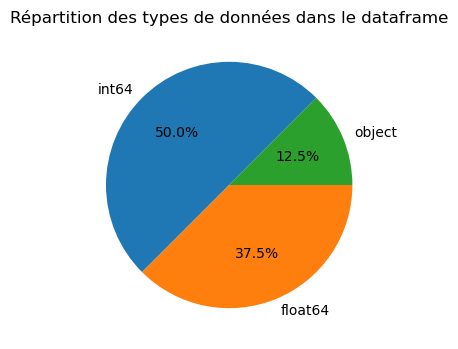

In [157]:
type_counts = df_pos_cash.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [158]:
df_pos_cash.describe(exclude= np.number)

,NAME_CONTRACT_STATUS_first
count,337252
unique,8
top,Completed
freq,188866


In [159]:
df_pos_cash.describe()

,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_size,SK_DPD_max,SK_DPD_mean,SK_DPD_DEF_max,SK_DPD_DEF_mean
count,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000
mean,-12.591605,-31.873263,29.655445,15.294106,4.296271,1.473355,0.225470
std,18.648620,20.081193,24.531971,151.343806,59.717229,32.337266,13.554576
min,-96.000000,-96.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-15.000000,-43.988354,12.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.000000,-28.571429,22.000000,0.000000,0.000000,0.000000,0.000000
75%,-2.000000,-15.500000,39.000000,0.000000,0.000000,0.000000,0.000000
max,-1.000000,-1.000000,295.000000,4231.000000,2622.078431,3595.000000,1740.554455


## Nettoyage des données catégorielles

In [160]:
df_pos_cash['NAME_CONTRACT_STATUS_first'].value_counts()

Completed                188866
Active                   147295
Signed                      802
Returned to the store       177
Demand                       67
Approved                     33
Amortized debt               11
Canceled                      1
Name: NAME_CONTRACT_STATUS_first, dtype: int64

## Nettoyage des données numériques

**Remarque :** A l'aperçu des données descriptives du dataframe, et bien que certaines valeurs puissent sembler élevées, il est possible d'interpréter ces éléments comme atypique plutot qu'aberrants en ajoutant le contexte et la connaissance métiers. Il pourrait être nécessaire d'enlever, par exemple, les clients avec beaucoup de jours de retards de règlements vers un service ou un fichier contentieux. Nous décidons de les conserver pour l'information qu'ils apportent. 

# Jeux de données installments_payments & credit_card_balance

In [161]:
df_installments.shape

(13605401, 8)

In [162]:
df_installments.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [163]:
df_installments['SK_ID_CURR'].duplicated().sum()

13265814

In [164]:
df_credit_card.shape

(3840312, 23)

In [165]:
df_credit_card.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [166]:
df_credit_card['SK_ID_CURR'].duplicated().sum()

3736754

## Analyse Exploratoire

In [167]:
df_installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [168]:
missing_values_installments = tabvaleurs_manquantes(df_installments)
missing_values_installments

Votre dataframe a 8 colonnes.
Il y a 2 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


In [169]:
# Aperçu des différents types de données

df_installments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

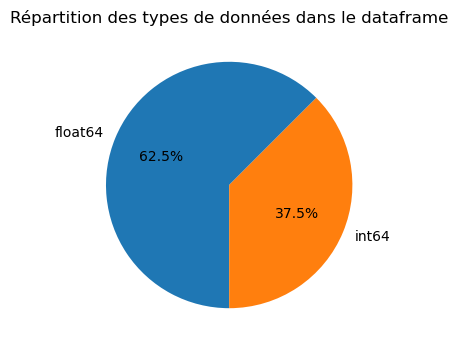

In [170]:
type_counts = df_installments.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [171]:
df_installments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [172]:
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [173]:
missing_values_credit_card = tabvaleurs_manquantes(df_credit_card)
missing_values_credit_card

Votre dataframe a 23 colonnes.
Il y a 9 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


In [174]:
# Aperçu des différents types de données

df_credit_card.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

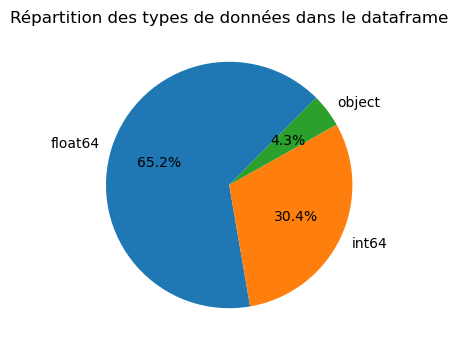

In [175]:
type_counts = df_credit_card.dtypes.value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Répartition des types de données dans le dataframe')
plt.show()

In [176]:
df_credit_card.describe(exclude = np.number)

,NAME_CONTRACT_STATUS
count,3840312
unique,7
top,Active
freq,3698436


In [177]:
df_credit_card.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,4.289207e+06,4.278316e+06,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


## Nettoyage des données catégorielles

In [178]:
df_credit_card['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

**Remarque :** Rien ne semble être à nettoyer sur les valeurs de cette variable.

## Nettoyage des données numériques

In [179]:
print(df_credit_card['MONTHS_BALANCE'].describe())

count    3.840312e+06
mean    -3.452192e+01
std      2.666775e+01
min     -9.600000e+01
25%     -5.500000e+01
50%     -2.800000e+01
75%     -1.100000e+01
max     -1.000000e+00
Name: MONTHS_BALANCE, dtype: float64


In [180]:
df_credit_card[df_credit_card['MONTHS_BALANCE']< -90]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
7336,2257340,308889,-95,80125.155,90000,0.0,0.0,0.0,0.0,4500.0,4500.0,4500.0,76925.790,80125.155,80125.155,0.0,0,0.0,0.0,6.0,Active,0,0
7339,2320395,399027,-91,88164.045,90000,0.0,0.0,0.0,0.0,5400.0,6750.0,6750.0,84584.520,88164.045,88164.045,0.0,0,0.0,0.0,19.0,Active,0,0
7340,1375139,261215,-93,69479.820,90000,0.0,0.0,0.0,0.0,4500.0,4500.0,4500.0,65263.455,69479.820,69479.820,0.0,0,0.0,0.0,8.0,Active,1,1
7341,2425168,131060,-93,60081.705,67500,0.0,0.0,0.0,0.0,4050.0,0.0,0.0,55449.090,60081.705,60081.705,0.0,0,0.0,0.0,10.0,Active,1,1
7343,2741894,152714,-91,132447.825,135000,0.0,0.0,0.0,0.0,6750.0,6750.0,6750.0,128320.335,132447.825,132447.825,0.0,0,0.0,0.0,6.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825980,1126275,137832,-96,0.000,135000,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.000,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0
3825981,2138083,322910,-96,62044.875,135000,0.0,0.0,0.0,0.0,4050.0,4050.0,4050.0,59533.605,62044.875,62044.875,0.0,0,0.0,0.0,6.0,Active,0,0
3825982,1730052,307822,-96,28308.600,90000,0.0,0.0,0.0,0.0,5400.0,6750.0,6750.0,27091.080,28308.600,28308.600,0.0,0,0.0,0.0,9.0,Active,0,0
3825983,1185595,279313,-96,0.000,135000,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.000,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0


**Remarque :** Nous avons voulu observer les durées longues seulement ces valeurs sont possibles dans le cadre d'un credit revolving. 

# Feature Engeneering

L'analyse exploratoire des données nous donne un bel aperçu des différentes features qui peuvent être pertinentes pour notre modèle de scoring crédit. 

Dans cette partie, nous effectuerons plus en détails le choix des variables que nous concerverons ainsi que la création de nouvelles colonnes liées à notre connaissance métiers. 

Concernant ces créations, nous souhaitons ajouter :  

- **Le taux d'endettement :** ratio des dettes sur les revenus, exprimé en pourcentage. Cet indicateur est primordial car selon la législation française, nous devons respecter des 'quotats' afin de protéger le consommateurs d'un risque de surrendettement. Ce taux ne peut pas dépasser 35% avec possibilité d'augmenter ce pourcentage avec la connaissance client et une analyse plus approfondie.     

Nous ajouterons également des features afin d'avoir la connaissances des charges financères totales, l'historique financement, des données de conformité (KYC) ainsi que des informations comportementales.

## train|test

In [181]:
# Aperçu des données manquantes
missing_values = tabvaleurs_manquantes(df)
missing_values.head(30)

Votre dataframe a 122 colonnes.
Il y a 69 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
COMMONAREA_AVG,248308,69.7
COMMONAREA_MEDI,248308,69.7
COMMONAREA_MODE,248308,69.7
NONLIVINGAPARTMENTS_MODE,246810,69.3
NONLIVINGAPARTMENTS_MEDI,246810,69.3
NONLIVINGAPARTMENTS_AVG,246810,69.3
FONDKAPREMONT_MODE,243042,68.2
LIVINGAPARTMENTS_MEDI,242928,68.2
LIVINGAPARTMENTS_AVG,242928,68.2
LIVINGAPARTMENTS_MODE,242928,68.2


In [182]:
# Suppression des features avec plus de 60% de données manquantes 

missing_percent = df.isnull().mean() * 100
features_to_drop = missing_percent[missing_percent > 60].index

df = df.drop(columns=features_to_drop)

In [183]:
# Nouvelles colonnes pour convertir les données jours en années 

df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365

df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] / -365

df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'] / -365
df['YEARS_LAST_PHONE_CHANGE'] = df['YEARS_LAST_PHONE_CHANGE'].apply(lambda x: np.sign(x) * x)

In [184]:
# Création de features de type analyse financière

# SPOUSE_PART : On attribue 0.5 part pour le conjoint (si la personne est mariée ou en union civile)
# CHILDREN_PART : Chaque enfant ajoute 0.3 parts au total. Cela reflète l'impact financier de chaque enfant sur le ménage.
# FAMILY_PARTS : Le total des parts est la somme de la part du requérant principal (toujours égale à 1), des parts du conjoint (si applicable), et des parts des enfants.
# DUREE : Création de la durée estimée de financement

df['SPOUSE_PART'] = np.where(df['NAME_FAMILY_STATUS'].isin(['Married', 'Civil marriage']), 0.5, 0)
df['CHILDREN_PART'] = df['CNT_CHILDREN'] * 0.3
df['FAMILY_PARTS'] = 1 + df['SPOUSE_PART'] + df['CHILDREN_PART']

df['DUREE'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

In [185]:
# Suppression des colonnes considérées comme inutiles ou déjà exploitées
features_to_drop = [
    'FLAG_OWN_CAR','AMT_GOODS_PRICE','NAME_TYPE_SUITE','REGION_POPULATION_RELATIVE','DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH','OCCUPATION_TYPE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT'
]
df.drop(columns=features_to_drop, inplace=True)

cols_to_drop = df.columns[df.columns.str.contains('AVG$|MODE$|MEDI$|CIRCLE$')]
df.drop(columns=cols_to_drop, inplace=True)

features_to_drop2 = [
    'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','SPOUSE_PART','CHILDREN_PART','FAMILY_PARTS'
]
df.drop(columns=features_to_drop2, inplace=True)

## Autres jeux de données

Afin d'enrichir nos bases de données initiales et 'actuelles', nous allons a partir des connaissances des features, effectuer des aggregations afin de faire ressortir les informations que nous souhaitons ajouter.  

*Les méthodes d'agrégation courantes incluent le calcul de la somme, de la moyenne, du minimum, du maximum, de la médiane, ou même des fonctions plus complexes comme des écarts-types ou des quantiles, selon ce qui est le plus pertinent pour la tâche d'analyse ou de modélisation à accomplir.*

In [186]:
# Création de features à partir de bureau|bureau_balance

# Nombre total de crédits actifs (autres établissements)
active_credits = df_b[df_b['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR')['CREDIT_ACTIVE'].count()
df = df.join(active_credits.rename('TOTAL_ACTIVE_CREDITS'), on='SK_ID_CURR')

# Montant total de la dette (autres établissements)
total_debt = df_b.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
df = df.join(total_debt.rename('TOTAL_DEBT'), on='SK_ID_CURR')

# Moyenne du montant maximal en retard de paiement
avg_max_overdue = df_b.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()
df = df.join(avg_max_overdue.rename('AVG_MAX_OVERDUE'), on='SK_ID_CURR')

In [187]:
df['TOTAL_ACTIVE_CREDITS'].describe()

count    251774.000000
mean          2.504333
std           1.670769
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          32.000000
Name: TOTAL_ACTIVE_CREDITS, dtype: float64

In [188]:
df[df['TOTAL_ACTIVE_CREDITS']>20]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,YEARS_EMPLOYED,YEARS_LAST_PHONE_CHANGE,DUREE,TOTAL_ACTIVE_CREDITS,TOTAL_DEBT,AVG_MAX_OVERDUE
43778,150685,1.0,Cash loans,F,Y,0.0,171000.0,835605.0,24561.0,Pensioner,Secondary / secondary special,Married,House / apartment,1.0,0.0,0.0,1.0,0.0,0.0,2.0,NaN,NaN,0.719807,0.122955,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,57.221918,NaN,1.594521,34.021620,22.0,1.881481e+06,970.2855
197745,329272,1.0,Cash loans,F,Y,0.0,225000.0,675382.5,26424.0,Working,Secondary / secondary special,Married,House / apartment,1.0,1.0,1.0,1.0,1.0,1.0,2.0,Business Entity,0.334851,0.492999,0.248536,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,35.898630,3.654795,0.934247,25.559435,32.0,9.461488e+06,0.0000
234374,371490,1.0,Cash loans,F,Y,0.0,189000.0,450000.0,22018.5,Working,Secondary / secondary special,Married,House / apartment,1.0,1.0,0.0,1.0,1.0,1.0,2.0,Trade,0.351141,0.007801,0.047601,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.334247,0.536986,3.742466,20.437359,22.0,1.140436e+07,NaN


**Remarque :** Si on se détache de la législation française ( jeu de données surement américain ), ce sont des valeurs atypiques mais pas aberrantes. La target renseignée est légitime au vue du nombre de crédit. Nous conservons les données. 

In [189]:
df['TOTAL_DEBT'].describe()

count    3.057580e+05
mean     6.539847e+05
std      1.640809e+06
min     -6.981558e+06
25%      0.000000e+00
50%      1.734232e+05
75%      6.766189e+05
max      3.344983e+08
Name: TOTAL_DEBT, dtype: float64

In [190]:
df[df['TOTAL_DEBT']<0]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,YEARS_EMPLOYED,YEARS_LAST_PHONE_CHANGE,DUREE,TOTAL_ACTIVE_CREDITS,TOTAL_DEBT,AVG_MAX_OVERDUE
161,100190,0.0,Cash loans,M,N,0.0,162000.0,263686.5,24781.5,Commercial associate,Higher education,Married,House / apartment,1.0,1.0,0.0,1.0,1.0,0.0,2.0,Government,0.534999,0.585859,0.788681,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,38.279452,12.252055,3.180822,10.640458,2.0,-77.760,4788.000000
189,100219,0.0,Cash loans,M,Y,1.0,315000.0,2250000.0,83515.5,Commercial associate,Higher education,Married,House / apartment,1.0,1.0,0.0,1.0,0.0,1.0,1.0,Business Entity,0.380092,0.693358,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,30.621918,4.147945,2.536986,26.941107,1.0,-88.830,0.000000
324,100372,0.0,Cash loans,F,N,0.0,90000.0,531000.0,29781.0,Pensioner,Secondary / secondary special,Married,House / apartment,1.0,0.0,0.0,1.0,1.0,0.0,2.0,NaN,NaN,0.673737,0.465069,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.024658,NaN,-0.000000,17.830160,1.0,-255.510,396.000000
683,100789,0.0,Cash loans,F,Y,0.0,112500.0,813195.0,24786.0,Working,Secondary / secondary special,Married,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,3.0,Business Entity,NaN,0.493130,0.767523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.736986,2.871233,3.186301,32.808642,2.0,-603.945,0.000000
932,101075,0.0,Cash loans,F,Y,0.0,121500.0,533668.5,37273.5,Working,Secondary / secondary special,Single / not married,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,1.0,Self-employed,NaN,0.683802,0.678568,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.561644,6.400000,3.153425,14.317639,1.0,-5117.130,424.884375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306327,454913,0.0,Cash loans,M,N,0.0,112500.0,1125000.0,36292.5,Working,Higher education,Married,With parents,1.0,1.0,1.0,1.0,0.0,0.0,3.0,Self-employed,0.247255,0.444113,0.754406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,31.400000,13.443836,4.649315,30.998140,3.0,-166.005,1920.000000
306607,455236,0.0,Cash loans,M,N,0.0,135000.0,225000.0,15660.0,Working,Secondary / secondary special,Married,House / apartment,1.0,1.0,1.0,1.0,1.0,0.0,1.0,School,NaN,0.604800,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.810959,10.947945,7.235616,14.367816,1.0,-132.795,3630.000000
306807,455464,0.0,Revolving loans,F,N,1.0,112500.0,270000.0,13500.0,Working,Secondary / secondary special,Single / not married,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,2.0,Business Entity,0.396158,0.679826,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.731507,11.389041,8.312329,20.000000,1.0,-1637.235,3600.000000
307334,456059,0.0,Cash loans,M,Y,0.0,157500.0,450000.0,17095.5,Working,Higher education,Married,House / apartment,1.0,1.0,1.0,1.0,1.0,0.0,2.0,Business Entity,NaN,0.661955,0.754406,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,38.312329,10.61

**Remarque :** Il peut s'agir de trop perçu lors des remboursements anticipées de financement. Dans notre cas, nous n'avons pas besoin du détails de cette information. Nous modifions ces valeurs par 0.

In [191]:
df.loc[df['TOTAL_DEBT'] < 0, 'TOTAL_DEBT'] = 0

In [192]:
df['AVG_MAX_OVERDUE'].describe()

count    2.129330e+05
mean     5.005541e+03
std      2.857074e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.063745e+03
max      1.159872e+08
Name: AVG_MAX_OVERDUE, dtype: float64

In [193]:
# Création de features à partir de previous_application

# Nombre total de demandes de prêt par client
total_loan = df_previous.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
df = df.join(total_loan.rename('TOTAL_LOAN_APP'), on='SK_ID_CURR', how='left')

# Montant moyen des crédits demandés
avg_credit_requested = df_previous.groupby('SK_ID_CURR')['AMT_APPLICATION'].mean()
df = df.join(avg_credit_requested.rename('AVG_CREDIT_REQUESTED'), on='SK_ID_CURR', how='left')

# Montant moyen des crédits accordés
avg_credit_granted = df_previous.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
df = df.join(avg_credit_granted.rename('AVG_CREDIT_GRANTED'), on='SK_ID_CURR', how='left')

# Statut moyen de l'assurance de prêt
insurance_status = df_previous.groupby('SK_ID_CURR')['NFLAG_INSURED_ON_APPROVAL'].mean()
df = df.join(insurance_status.rename('AVG_INSURANCE_STATUS'), on='SK_ID_CURR', how='left')

In [194]:
df['TOTAL_LOAN_APP'].describe()

count    338749.000000
mean          4.922863
std           4.214745
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          77.000000
Name: TOTAL_LOAN_APP, dtype: float64

In [195]:
df['AVG_CREDIT_REQUESTED'].describe()

count    3.387490e+05
mean     1.545187e+05
std      1.526787e+05
min      0.000000e+00
25%      6.260962e+04
50%      1.068540e+05
75%      1.917990e+05
max      4.050000e+06
Name: AVG_CREDIT_REQUESTED, dtype: float64

In [196]:
df['AVG_INSURANCE_STATUS'].describe()

count    337226.000000
mean          0.280510
std           0.318304
min           0.000000
25%           0.000000
50%           0.200000
75%           0.500000
max           1.000000
Name: AVG_INSURANCE_STATUS, dtype: float64

In [197]:
# Moyenne des jours de retard de paiement
avg_days_past_due = df_pos_cash.groupby('SK_ID_CURR')['SK_DPD_max'].mean()
df = df.join(avg_days_past_due.rename('AVG_DAYS_PAST_DUE'), on='SK_ID_CURR', how='left')

# Moyenne des retards non régularisés après un certain délai
avg_days_past_due_def = df_pos_cash.groupby('SK_ID_CURR')['SK_DPD_DEF_max'].mean()
df = df.join(avg_days_past_due_def.rename('AVG_DAYS_PAST_DUE_DEF'), on='SK_ID_CURR', how='left')

In [198]:
df['AVG_DAYS_PAST_DUE'].describe()

count    337188.000000
mean         15.294601
std         151.355371
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4231.000000
Name: AVG_DAYS_PAST_DUE, dtype: float64

In [199]:
df['AVG_DAYS_PAST_DUE_DEF'].describe()

count    337188.000000
mean          1.472908
std          32.339769
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3595.000000
Name: AVG_DAYS_PAST_DUE_DEF, dtype: float64

In [200]:
# Création de features à partir des datasets installments_payments et credit_card

# Paiements en retard dans installments_payments
df_installments['IS_LATE'] = df_installments['DAYS_ENTRY_PAYMENT'] > df_installments['DAYS_INSTALMENT']

# Pourcentage de paiements en retard pour chaque client
percent_late_payments = df_installments.groupby('SK_ID_CURR')['IS_LATE'].mean().rename('PERCENT_LATE_PAYMENTS')
df = df.join(percent_late_payments, on='SK_ID_CURR', how='left')

# Paiements en retard dans le dataset credit_card
df_credit_card['LATE_PAYMENT'] = df_credit_card['SK_DPD'] > 0

# Statut global des paiements par carte pour chaque client
card_payment_status = df_credit_card.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean().rename('CARD_PAYMENT_STATUS')
df = df.join(card_payment_status, on='SK_ID_CURR', how='left')

In [201]:
df['PERCENT_LATE_PAYMENTS'].describe()

count    339523.000000
mean          0.074380
std           0.114485
min           0.000000
25%           0.000000
50%           0.017857
75%           0.109375
max           1.000000
Name: PERCENT_LATE_PAYMENTS, dtype: float64

In [202]:
df['CARD_PAYMENT_STATUS'].describe()

count    103543.000000
mean          0.020029
std           0.076487
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: CARD_PAYMENT_STATUS, dtype: float64

In [203]:
# Creation de feature de type financières

# Taux d'endettement : Indicateur qui montre quel pourcentage du revenu d'un client est utilisé pour rembourser ses dettes.
# En France, la norme est un respect de 35% de taux d'endettement avec possibilité de dépasser d'environ 20% supplémentaires avec analyse approfondie.

df['TX_ENDETTEMENT'] = (df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']) * 100

In [204]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,YEARS_EMPLOYED,YEARS_LAST_PHONE_CHANGE,DUREE,TOTAL_ACTIVE_CREDITS,TOTAL_DEBT,AVG_MAX_OVERDUE,TOTAL_LOAN_APP,AVG_CREDIT_REQUESTED,AVG_CREDIT_GRANTED,AVG_INSURANCE_STATUS,AVG_DAYS_PAST_DUE,AVG_DAYS_PAST_DUE_DEF,PERCENT_LATE_PAYMENTS,CARD_PAYMENT_STATUS,TX_ENDETTEMENT
0,100002,1.0,Cash loans,M,Y,0.0,202500.0,406597.5,24700.5,Working,Secondary / secondary special,Single / not married,House / apartment,1.0,1.0,0.0,1.0,1.0,0.0,2.0,Business Entity,0.083037,0.262949,0.139376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.920548,1.745205,3.106849,16.461104,2.0,245781.000,1681.029,1.0,179055.0000,179055.0000,0.000000,0.0,0.0,0.000000,NaN,12.197778
1,100003,0.0,Cash loans,F,N,0.0,270000.0,1293502.5,35698.5,State servant,Higher education,Married,House / apartment,1.0,1.0,0.0,1.0,1.0,0.0,1.0,School,0.311267,0.622246,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.931507,3.254795,2.268493,36.234085,1.0,0.000,0.000,3.0,435436.5000,484191.0000,0.666667,0.0,0.0,0.000000,NaN,13.221667
2,100004,0.0,Revolving loans,M,Y,0.0,67500.0,135000.0,6750.0,Working,Secondary / secondary special,Single / not married,House / apartment,1.0,1.0,1.0,1.0,1.0,0.0,2.0,Government,NaN,0.555912,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.180822,0.616438,2.232877,20.000000,NaN,0.000,0.000,1.0,24282.0000,20106.0000,0.000000,0.0,0.0,0.000000,NaN,10.000000
3,100006,0.0,Cash loans,F,Y,0.0,135000.0,312682.5,29686.5,Working,Secondary / secondary special,Civil marriage,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,2.0,Business Entity,NaN,0.650442,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,52.068493,8.326027,1.690411,10.532818,NaN,NaN,NaN,9.0,272203.2600,291695.5000,0.000000,0.0,0.0,0.000000,0.0,21.990000
4,100007,0.0,Cash loans,M,Y,0.0,121500.0,513000.0,21865.5,Working,Secondary / secondary special,Single / not married,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,2.0,Religion,NaN,0.322738,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.608219,8.323288,3.030137,23.461618,NaN,0.000,0.000,6.0,150530.2500,166638.7500,0.600000,0.0,0.0,0.242424,NaN,17.996296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,Y,0.0,121500.0,412560.0,17473.5,Working,Secondary / secondary special,Widow,House / apartment,1.0,1.0,1.0,1.0,1.0,0.0,3.0,Other,NaN,0.648575,0.643026,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.712329,14.161644,1.873973,23.610610,2.0,556470.000,11427.750,1.0,225000.0000,254700.0000,1.000000,0.0,0.0,0.000000,NaN,14.381481
356251,456222,NaN,Cash loans,F,N,2.0,157500.0,622413.0,31909.5,Commercial associate,Secondary / secondary special,Married,House / apartment,1.0,1.0,0.0,1.0,0.0,0.0,2.0,Trade,NaN,0.684596,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30.646575,3.147945,-0.000000,19.505570,NaN,NaN,NaN,4.0,86871.3750,98704.1250,0.500000,0.0,0.0,0.0

## Transformation des features

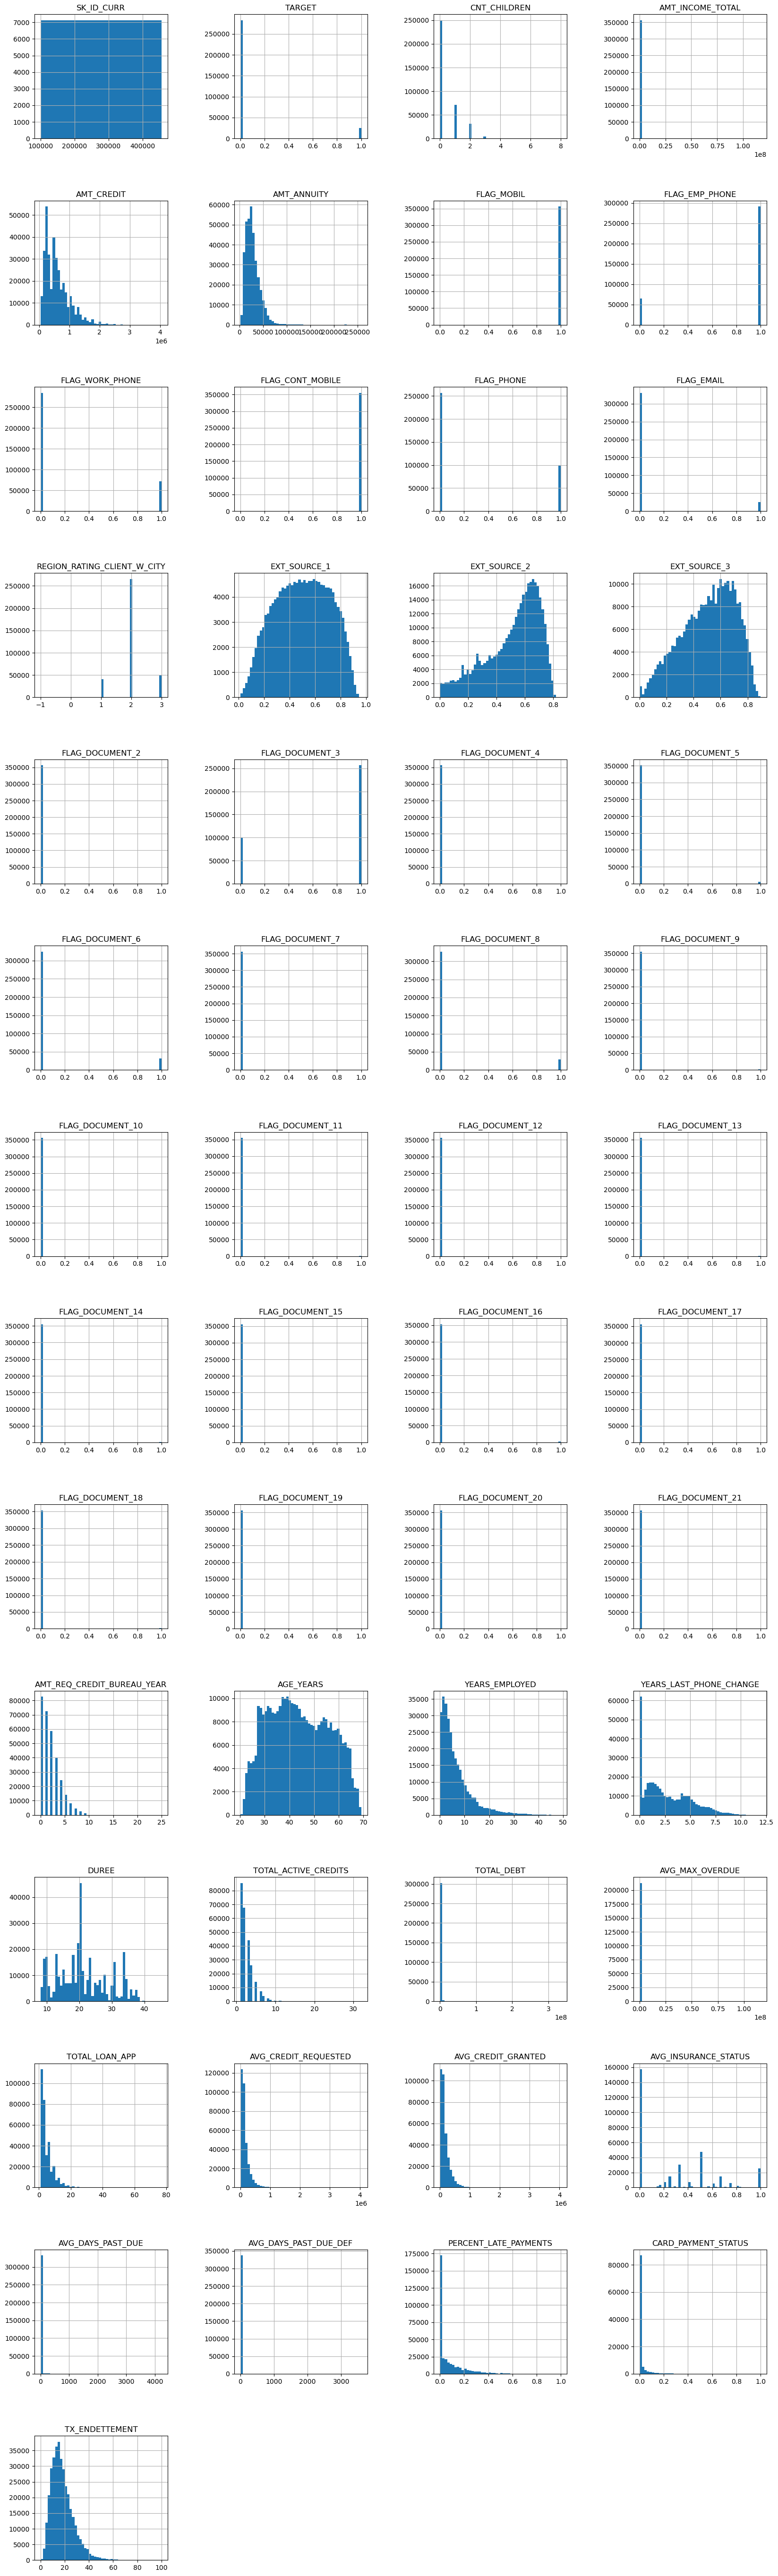

In [205]:
# Graphiques de la répartition des features numériques

numerical_cols = df.select_dtypes(include=['int64', 'float64'])

n_cols = 4
n_rows = int(np.ceil(len(numerical_cols.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, col in enumerate(numerical_cols.columns):
    ax = axes[i // n_cols, i % n_cols]
    numerical_cols[col].hist(bins=50, ax=ax)
    ax.set_title(col)

for i in range(len(numerical_cols.columns), n_rows * n_cols):
    axes.flat[i].set_visible(False)

plt.show()

In [206]:
# Transformation Log sur les features sélectionnées ( selon les graphiques )
columns_to_transform = ['AMT_CREDIT', 'AMT_ANNUITY','AMT_INCOME_TOTAL', 'YEARS_EMPLOYED','YEARS_LAST_PHONE_CHANGE',
                        'TOTAL_ACTIVE_CREDITS','TOTAL_DEBT','AVG_MAX_OVERDUE','TOTAL_LOAN_APP','AVG_CREDIT_REQUESTED',
                        'AVG_CREDIT_GRANTED', 'AVG_DAYS_PAST_DUE_DEF','PERCENT_LATE_PAYMENTS','CARD_PAYMENT_STATUS',
                       'TX_ENDETTEMENT']

apply_log_transform(df, columns_to_transform)

In [207]:
correlations = df.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 TOTAL_DEBT                     0.011879
TOTAL_LOAN_APP                 0.012383
TX_ENDETTEMENT                 0.017685
CARD_PAYMENT_STATUS            0.018697
CNT_CHILDREN                   0.019026
AMT_REQ_CREDIT_BUREAU_YEAR     0.019947
FLAG_WORK_PHONE                0.028537
AVG_MAX_OVERDUE                0.035447
FLAG_DOCUMENT_3                0.044423
FLAG_EMP_PHONE                 0.046038
AVG_DAYS_PAST_DUE_DEF          0.046281
TOTAL_ACTIVE_CREDITS           0.054042
REGION_RATING_CLIENT_W_CITY    0.060876
PERCENT_LATE_PAYMENTS          0.067300
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3              -0.178937
EXT_SOURCE_2              -0.160487
EXT_SOURCE_1              -0.155289
YEARS_EMPLOYED            -0.079404
AGE_YEARS                 -0.078282
YEARS_LAST_PHONE_CHANGE   -0.051783
DUREE                     -0.032206
AVG_CREDIT_REQUESTED      -0.030613
FLAG_DOCUMENT_6         

In [208]:
corr = df.corr()

high_corr_pairs = get_high_correlations(df, threshold=0.7)
high_corr_pairs

,Feature_1,Feature_2,Correlation
0,AMT_ANNUITY,AMT_CREDIT,0.839732
1,AVG_CREDIT_GRANTED,AVG_CREDIT_REQUESTED,0.953443


In [209]:
# Suppression des caractéristiques trop corrélées
columns_to_drop = [
    'AMT_ANNUITY',
    'AVG_CREDIT_REQUESTED'
]

df = df.drop(columns=columns_to_drop)

In [210]:
# Aperçu des données manquantes
missing_values = tabvaleurs_manquantes(df)
missing_values.head(30)

Votre dataframe a 59 colonnes.
Il y a 20 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs
CARD_PAYMENT_STATUS,335528,94.2
AVG_DAYS_PAST_DUE_DEF,310250,87.1
AVG_MAX_OVERDUE,275899,77.5
EXT_SOURCE_1,193875,54.4
PERCENT_LATE_PAYMENTS,176377,49.5
TOTAL_DEBT,140726,39.5
TOTAL_ACTIVE_CREDITS,104412,29.3
EXT_SOURCE_3,69611,19.5
YEARS_EMPLOYED,64625,18.1
ORGANIZATION_TYPE,64623,18.1


In [211]:
# Suppression des features avec plus de 60% de données manquantes 

missing_percent = df.isnull().mean() * 100
features_to_drop = missing_percent[missing_percent > 40].index

df = df.drop(columns=features_to_drop)

In [212]:
# Suppression des lignes où la cible 'TARGET' est NaN
df = df.dropna(subset=['TARGET'])

# ID clients en index pour conservation
df = df.set_index('SK_ID_CURR')

# Séparation des caractéristiques (X) et de la cible (y)
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [213]:
# Séparation des variables numériques et catégorielles
num_features = X.select_dtypes(include=['float64', 'int64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Imputation pour les caractéristiques numériques
imputer_num = SimpleImputer(strategy='median')
X[num_features] = imputer_num.fit_transform(X[num_features])

# Imputation pour les caractéristiques catégorielles
imputer_cat = SimpleImputer(strategy='most_frequent')
X[cat_features] = imputer_cat.fit_transform(X[cat_features])

In [214]:
# Séparation en train | test à hauteur de 20 % pour le test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:
# Fonction LabelEncoder sur l'ensemble d'entraînement
X_train = le_encoder(X_train)

4 colonnes ont été encodées.


In [216]:
# Fonction OneHotEncoder sur l'ensemble d'entraînement
X_train = one_hot_encoder(X_train)

In [217]:
# Création de nouvelles variables de type conformité sur l'ensemble d'entraînement

# CONTACT_SCORE : Création d'un score concernant les informations de contact données par le client. 
# NB : Les données ont été encodé avec 0/1 car 2 catégories uniques.

X_train['CONTACT_SCORE'] = (X_train['FLAG_MOBIL'] + X_train['FLAG_EMP_PHONE'] +
                            X_train['FLAG_WORK_PHONE'] + X_train['FLAG_CONT_MOBILE'] +
                            X_train['FLAG_PHONE'] + X_train['FLAG_EMAIL'])

# TOTAL_DOCUMENTS_SUBMITTED : Création d'un 'score' concernant la réception des documents. 
# NB : Les données ont été encodé avec 0/1 car 2 catégories uniques.

document_flags = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

X_train['TOTAL_DOCUMENTS_SUBMITTED'] = X_train[document_flags].sum(axis=1)
X_train.drop(columns=document_flags, inplace=True)

In [218]:
columns_to_drop = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 
                   'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']

X_train.drop(columns=columns_to_drop, inplace=True)

In [219]:
# Corrélation forte dans X_train après ajout de nouvelles features (encodage + création de features)
high_corr_pairs = get_high_correlations(X_train, threshold=0.7)
high_corr_pairs

,Feature_1,Feature_2,Correlation
0,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,-0.888035
1,TOTAL_DOCUMENTS_SUBMITTED,NAME_CONTRACT_TYPE,-0.774806


In [220]:
# Suppression des features trop corrélées ensemble.

columns_to_drop = [
    'NAME_EDUCATION_TYPE_Secondary / secondary special',
    'TOTAL_DOCUMENTS_SUBMITTED',   
]

X_train = X_train.drop(columns=columns_to_drop)

In [221]:
# Fonction LabelEncoder sur l'ensemble de test
X_test = le_encoder(X_test)

4 colonnes ont été encodées.


In [222]:
# Fonction OneHotEncoder sur l'ensemble de test
X_test = one_hot_encoder(X_test)

In [223]:
# Création de nouvelles variables de type conformité sur l'ensemble d'entraînement

# CONTACT_SCORE : Création d'un score concernant les informations de contact données par le client. 
# NB : Les données ont été encodé avec 0/1 car 2 catégories uniques.

X_test['CONTACT_SCORE'] = (X_test['FLAG_MOBIL'] + X_test['FLAG_EMP_PHONE'] +
                            X_test['FLAG_WORK_PHONE'] + X_test['FLAG_CONT_MOBILE'] +
                            X_test['FLAG_PHONE'] + X_test['FLAG_EMAIL'])


document_flags = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

# Nous n'ajoutons pas la création de TOTAL_DOCUMENTS_SUBMITTED au vue des corrélations constastées sur X_train
X_test.drop(columns=document_flags, inplace=True)

columns_to_drop = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 
                   'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']

X_test.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns='NAME_EDUCATION_TYPE_Secondary / secondary special',inplace=True)

In [224]:
# Aperçu des données manquantes
missing_values = tabvaleurs_manquantes(X_train)
missing_values

Votre dataframe a 69 colonnes.
Il y a 0 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs


In [225]:
# Aperçu des données manquantes
missing_values = tabvaleurs_manquantes(X_test)
missing_values

Votre dataframe a 69 colonnes.
Il y a 0 colonnes qui ont des valeurs manquantes.


,Valeurs Manquantes,% du Total des Valeurs


In [226]:
# Enregistrement de X_test 
data_path = 'C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Data\\test_data.csv'
X_test.to_csv(data_path, index=True)

# Modélisation

Dans le cadre de notre projet de scoring de crédit, l'objectif est de développer un modèle prédictif capable de déterminer la probabilité qu'un client rembourse son crédit. Cette capacité de prédiction est cruciale pour réduire le risque financier et améliorer la décision d'octroi de crédit. Pour ce faire, nous avons choisi d'explorer différents modèles de machine learning.  

**Modèles sélectionnés :**  
- **DummyClassifier (Baseline) :** Il sert de point de référence basique pour évaluer l'efficacité des autres modèles. Ce modèle ne fait aucune distinction entre les profils des clients et attribue une décision basée sur la stratégie la plus simple (par exemple, prédire la classe la plus fréquente). L'utilisation de ce modèle nous permet de mesurer l'augmentation de performance obtenue avec des approches plus sophistiquées.  
- **Régression Logistique :** C'est un modèle linéaire classique en statistiques qui est souvent utilisé pour les problèmes de classification binaire, comme c'est le cas avec le scoring de crédit. Ce modèle est apprécié pour sa simplicité, son interprétabilité et sa capacité à fournir des probabilités directes de défaut de paiement.  

- **Random Forest Classifier :** C'est un ensemble d'arbres de décision. Cette méthode est reconnue pour sa robustesse face aux surajustements et sa capacité à gérer de grandes quantités de données et de features. Elle est particulièrement efficace pour capturer des interactions complexes entre variables sans nécessiter une transformation extensive des données.  

- **LightGBM Classifier :** C'est un algorithme de boosting basé sur le gradient qui est optimisé pour être extrêmement efficace en termes de mémoire et de vitesse. LightGBM est particulièrement puissant pour traiter de grands volumes de données et peut gérer efficacement des données catégorielles, ce qui est souvent le cas dans les données de crédit.



In [227]:
# Configuration de l'expérience MLflow pour le suivi des modèles
mlflow.set_experiment('credit_risk_prediction')

2024/05/23 22:59:37 INFO mlflow.tracking.fluent: Experiment with name 'credit_risk_prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/628270070617359169', creation_time=1716497977980, experiment_id='628270070617359169', last_update_time=1716497977980, lifecycle_stage='active', name='credit_risk_prediction', tags={}>

In [228]:
# Validation croisée stratifiée
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métriques à évaluer avec cross_validate
scoring = {'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}

# Liste pour stocker les résultats
all_results = []

# Liste pour stocker les résultats Best Model
best_model = []

In [229]:
# Pipeline avec standardisation

def full_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

DummyClassifier Results:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5
Accuracy: 0.9193743800017666
Optimal Threshold: 0.01
Optimal Business Cost: 198310
Training Time: 0.43073058128356934
Train AUC: 0.5
Test AUC: 0.5


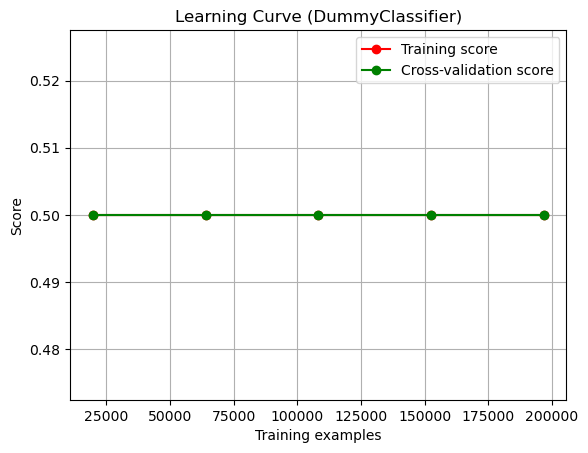

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370             0.0
320801             0.0
373937             0.0
119937             0.0
234683             0.0


3959

In [230]:
# DummyClassifier comme baseline
dummy_clf = DummyClassifier(strategy='most_frequent')
results_dummy, test_results_dummy = evaluate_model(dummy_clf, 'DummyClassifier', X_train, y_train, X_test, y_test, scoring, stratified_kfold)
all_results.append(results_dummy)
gc.collect()

Best parameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
LogisticRegression Results:
Precision: 0.15552751914908491
Recall: 0.6657254167354706
F1 Score: 0.25214700817036023
ROC AUC: 0.7362912948742613
Accuracy: 0.6815956666140375
Optimal Threshold: 0.52
Optimal Business Cost: 137315
Training Time: 139.59746670722961
Train AUC: 0.7375637452085266
Test AUC: 0.7403059496797809


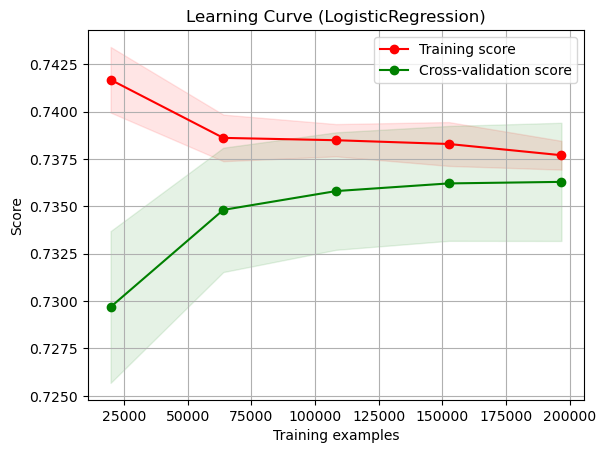

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.608754
320801        0.427994
373937        0.279737
119937        0.585295
234683        0.346451


4008

In [231]:
# Logistic Regression
lr_clf = LogisticRegression(random_state=42, class_weight='balanced')
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga'],
}
results_lr, test_results_lr = evaluate_model(lr_clf, 'LogisticRegression', X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid_lr)
all_results.append(results_lr)
gc.collect()

Best parameters for RandomForestClassifier: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
RandomForestClassifier Results:
Precision: 0.1706088905676081
Recall: 0.6126270043542534
F1 Score: 0.2668899671692343
ROC AUC: 0.7394047592805066
Accuracy: 0.7286391438150008
Optimal Threshold: 0.49
Optimal Business Cost: 135635
Training Time: 436.13626170158386
Train AUC: 0.7957392395952804
Test AUC: 0.7442716333018131


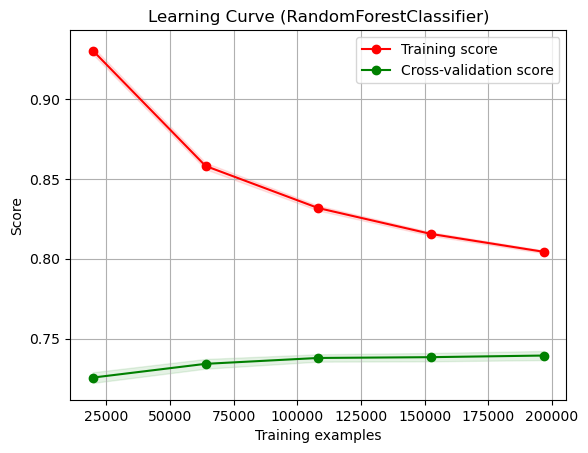

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.563330
320801        0.369425
373937        0.179901
119937        0.524034
234683        0.334644


4035

In [232]:
# RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
}

results_rf, test_results_rf = evaluate_model(rf_clf, 'RandomForestClassifier', X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid_rf)
all_results.append(results_rf)
gc.collect()

[LightGBM] [Info] Number of positive: 19831, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3378
[LightGBM] [Info] Number of data points in the train set: 245964, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters for LightGBMClassifier: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100}
[LightGBM] [Info] Number of positive: 15865, number of negative: 180906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[

Successfully registered model 'LightGBMClassifier'.
2024/05/23 23:26:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBMClassifier, version 1
Created version '1' of model 'LightGBMClassifier'.


LightGBMClassifier Results:
Precision: 0.16396056590628177
Recall: 0.6813575716250087
F1 Score: 0.26431539270954096
ROC AUC: 0.752966951483858
Accuracy: 0.6941869567964034
Optimal Threshold: 0.51
Optimal Business Cost: 131963
Training Time: 71.0669310092926
Train AUC: 0.7711957203301811
Test AUC: 0.75971252308092


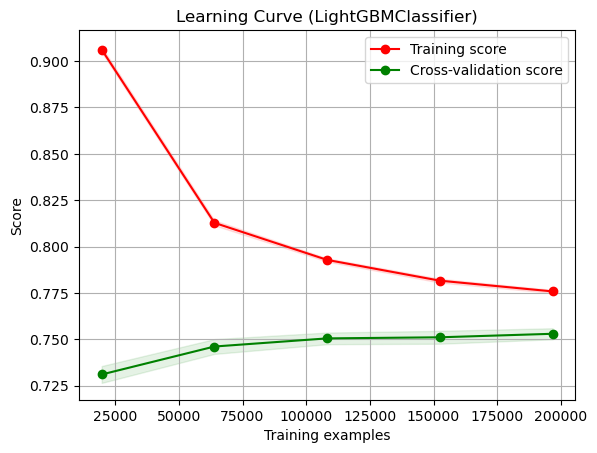

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.439038
320801        0.381219
373937        0.123004
119937        0.559165
234683        0.321943


4165

In [233]:
# LightGBMClassifier 
lgb_clf = lgb.LGBMClassifier(
    nthread=4,
    class_weight='balanced',
    random_state=42
)
param_grid_lgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.02, 0.05],
}
results_lgb, test_results_lgb = evaluate_model(lgb_clf, 'LightGBMClassifier', X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid_lgb)
all_results.append(results_lgb)
gc.collect()

In [234]:
# Affichage des résultats 
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df

,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy,Optimal Threshold,Optimal Business Cost,Train AUC,Test AUC,Training Time
0,DummyClassifier,0.000000,0.000000,0.000000,0.500000,0.919374,0.01,198310,0.500000,0.500000,0.430731
1,LogisticRegression,0.155528,0.665725,0.252147,0.736291,0.681596,0.52,137315,0.737564,0.740306,139.597467
2,RandomForestClassifier,0.170609,0.612627,0.266890,0.739405,0.728639,0.49,135635,0.795739,0.744272,436.136262
3,LightGBMClassifier,0.163961,0.681358,0.264315,0.752967,0.694187,0.51,131963,0.771196,0.759713,71.066931


Le modèle DummyClassifier, servant de référence, montre des scores très bas dans toutes les métriques, comme attendu pour un classificateur aléatoire. En comparaison, le LogisticRegression montre une amélioration substantielle, notamment en termes de ROC AUC et de précision, ce qui indique une capacité à distinguer les classes de manière plus efficace que le modèle de base.

Le RandomForestClassifier et le LightGBMClassifier montrent tous deux de meilleures performances, avec des scores particulièrement élevés en ROC AUC, ce qui suggère une très bonne capacité à classer correctement les instances positives et négatives. Le LightGBMClassifier surpasse les autres modèles en termes de temps d'entraînement et de coût métier optimal, tout en maintenant de bons scores de précision, rappel et F1, ce qui en fait le modèle le plus performant parmi ceux testés.

## Rééchantillonage avec SMOTE

Le SMOTE est une technique de rééchantillonnage conçue pour lutter contre le problème de déséquilibre des classes dans les ensembles de données de machine learning. Plutôt que de simplement dupliquer les exemples de la classe minoritaire, SMOTE crée de nouvelles instances synthétiques en interpolant entre des instances existantes. Cette méthode permet d'augmenter la diversité des exemples dans la classe minoritaire, aidant ainsi à éviter le surapprentissage et à améliorer la performance des modèles sur des données non vues en permettant au modèle de mieux généraliser.

In [235]:
# Création du pipeline avec StandardScaler et SMOTE
def smote_pipeline(model):
    return ImbPipeline([
        ('standardisation', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

Best parameters for LogisticRegression: {'classifier__C': 0.01, 'classifier__solver': 'liblinear'}
LogisticRegression Results:
Precision: 0.1552947472642646
Recall: 0.6581110602205971
F1 Score: 0.25129126211211833
ROC AUC: 0.73312452345354
Accuracy: 0.6838033071202945
Optimal Threshold: 0.53
Optimal Business Cost: 138438
Training Time: 330.74334692955017
Train AUC: 0.7342993216685896
Test AUC: 0.7369936425439243


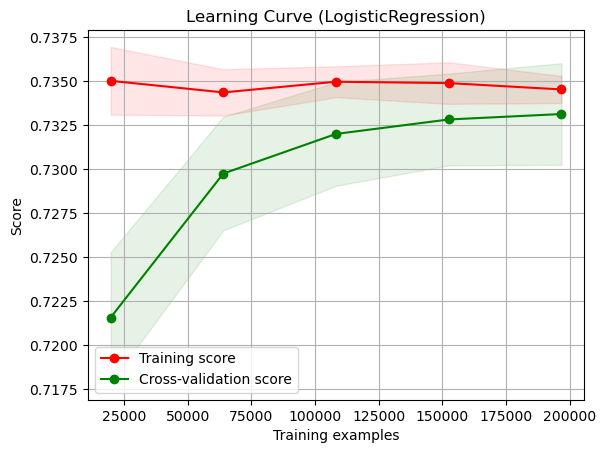

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.592113
320801        0.440247
373937        0.213560
119937        0.606158
234683        0.349955


4094

In [236]:
# Logistic Regression + SMOTE
lr_clf = LogisticRegression(random_state=42)
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga'],
}

tag = "SMOTE"

results_lr_smote, test_results_lr_smote = evaluate_model_with_smote(lr_clf, 'LogisticRegression', X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid_lr,tag)
all_results.append(results_lr_smote)
gc.collect()

[LightGBM] [Info] Number of positive: 226133, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8792
[LightGBM] [Info] Number of data points in the train set: 452266, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters for LightGBMClassifier: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200}
[LightGBM] [Info] Number of positive: 180906, number of negative: 180906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8980
[LightGBM] [Info] Number of data points in the train

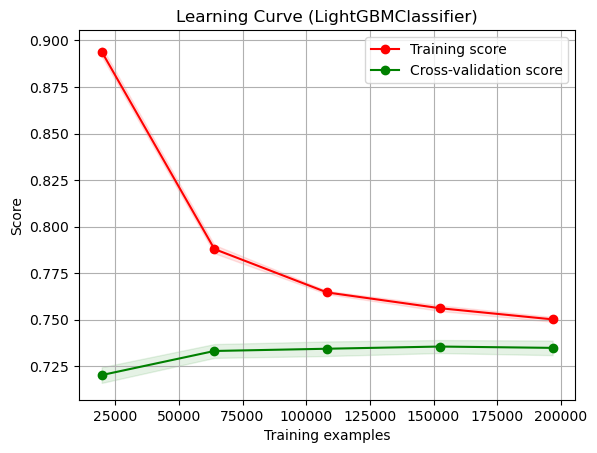

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.111998
320801        0.182670
373937        0.028637
119937        0.112072
234683        0.075031


4022

In [237]:
# LightGBMClassifier + SMOTE
lgb_clf = lgb.LGBMClassifier(
    nthread=4,
    random_state=42
)
param_grid_lgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.02, 0.05],
}

tag = "SMOTE"

results_lgb_smote, test_results_lgb_smote = evaluate_model_with_smote(lgb_clf, 'LightGBMClassifier', X_train, y_train, X_test, y_test, scoring, stratified_kfold, param_grid_lgb,tag)
all_results.append(results_lgb_smote)
gc.collect()

In [238]:
# Résultats avec les SMOTEs
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df

,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy,Optimal Threshold,Optimal Business Cost,Train AUC,Test AUC,Training Time
0,DummyClassifier,0.000000,0.000000,0.000000,0.500000,0.919374,0.01,198310,0.500000,0.500000,0.430731
1,LogisticRegression,0.155528,0.665725,0.252147,0.736291,0.681596,0.52,137315,0.737564,0.740306,139.597467
2,RandomForestClassifier,0.170609,0.612627,0.266890,0.739405,0.728639,0.49,135635,0.795739,0.744272,436.136262
3,LightGBMClassifier,0.163961,0.681358,0.264315,0.752967,0.694187,0.51,131963,0.771196,0.759713,71.066931
4,LogisticRegression,0.155295,0.658111,0.251291,0.733125,0.683803,0.53,138438,0.734299,0.736994,330.743347
5,LightGBMClassifier,0.405463,0.018960,0.036198,0.734815,0.918651,0.12,138191,0.745818,0.739792,173.445163


Sur la base des résultats obtenus, les modèles de LightGBM et la Régression Logistique sont sélectionnés pour la phase suivante du projet. Ces modèles offrent un bon équilibre entre les différentes métriques de performance et démontrent leur capacité à traiter efficacement le problème de scoring de crédit. LightGBM, en particulier, se distingue par son temps d'entraînement rapide et sa performance robuste sur l'ensemble des données, tandis que la Régression Logistique offre une bonne interprétabilité et un compromis acceptable entre rappel et précision.

## Importance Features

**L'importance des caractéristiques** est une approche analytique utilisée pour évaluer la contribution de chaque caractéristique à la performance d'un modèle de prédiction. En identifiant les variables les plus influentes, on peut comprendre mieux les dynamiques sous-jacentes des données et du modèle. Cette compréhension peut conduire à des améliorations significatives du modèle, notamment en termes de précision, d'efficacité et de simplification de l'explication des résultats.

**La sélection de caractéristiques**, quant à elle, consiste à choisir un sous-ensemble de caractéristiques les plus pertinentes à partir d'un ensemble plus vaste, ce qui peut aider à réduire la dimensionnalité, à améliorer la performance du modèle, et à réduire les coûts de calcul et de stockage. En se basant sur les caractéristiques les plus importantes identifiées à partir des deux meilleurs modèles, cette méthode cible non seulement l'optimisation des ressources mais favorise également l'élaboration de modèles plus robustes et généralisables, en évitant le surajustement et en renforçant la capacité du modèle à bien fonctionner sur de nouvelles données non vues.

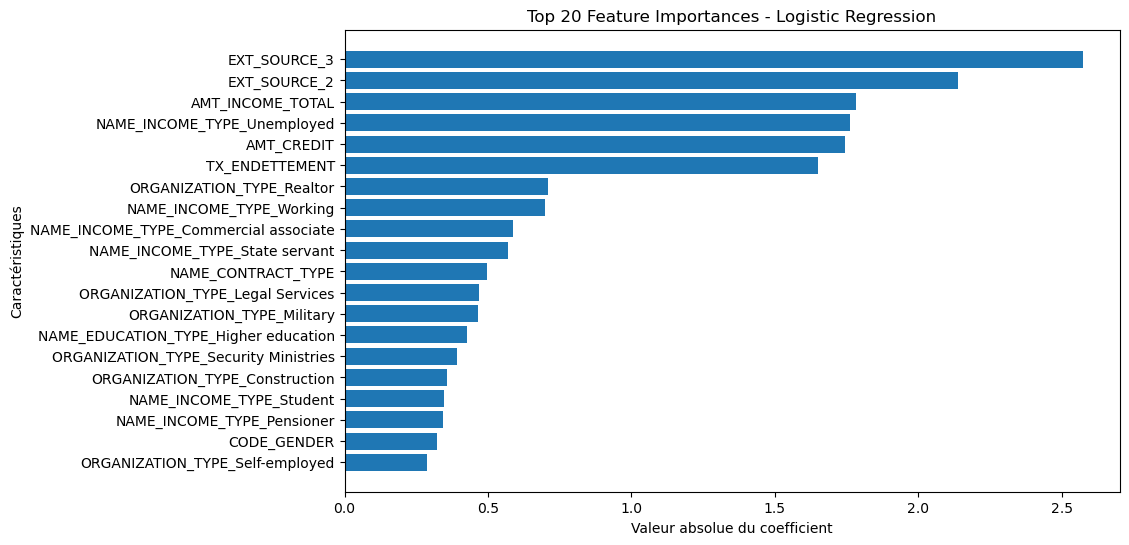

In [239]:
# Entraînement du modèle de régression logistique avec les meilleurs hyperparamètres trouvés
log_reg = LogisticRegression(
    max_iter=100,
    random_state=42,
    C=10,          # Meilleur hyperparamètre trouvé
    solver='liblinear'  # Meilleur hyperparamètre trouvé
)
log_reg.fit(X_train, y_train)

# Récupération des coefficients
coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': log_reg.coef_[0]
})

# Tri par valeur absolue
coefficients['abs_coefficient'] = np.abs(coefficients['coefficient'])
coefficients = coefficients.sort_values(by='abs_coefficient', ascending=False)

# Affichage graphique des 20 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(coefficients['feature'][:20][::-1], coefficients['abs_coefficient'][:20][::-1])
plt.xlabel('Valeur absolue du coefficient')
plt.ylabel('Caractéristiques')
plt.title('Top 20 Feature Importances - Logistic Regression')
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19831, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 245964, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080626 -> initscore=-2.433877
[LightGBM] [Info] Start training from score -2.433877


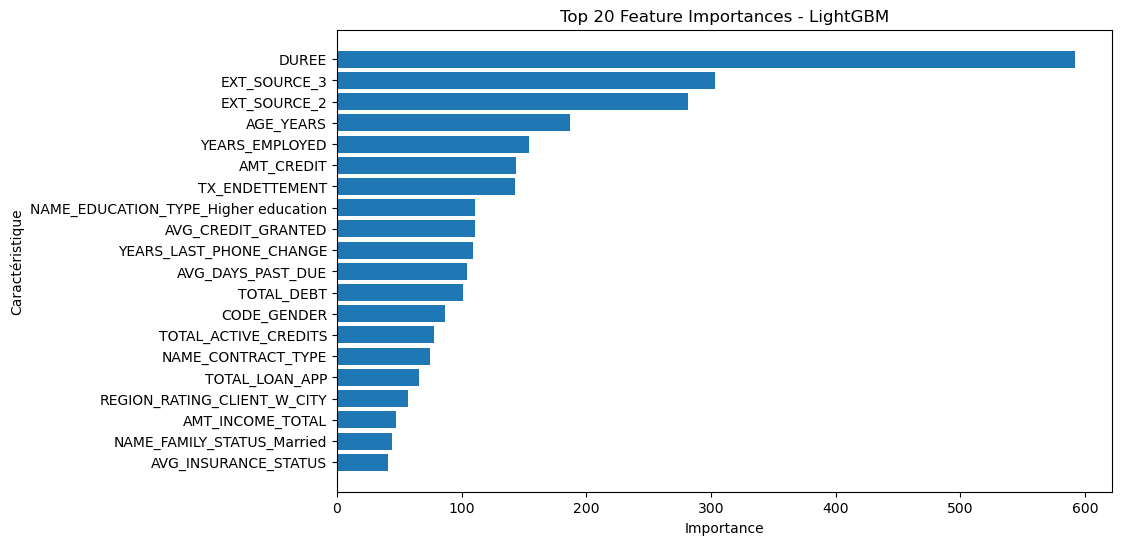

In [240]:
# Entraînement du modèle LightGBM avec les meilleurs hyperparamètres trouvés
lgbm = lgb.LGBMClassifier(
    random_state=42,
    learning_rate=0.05,  # Meilleur hyperparamètre trouvé
    n_estimators=100     # Meilleur hyperparamètre trouvé
)
lgbm.fit(X_train, y_train)

# Récupération de l'importance des caractéristiques
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
})

# Tri des caractéristiques par importance décroissante
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Affichage des 20 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'][:20][::-1], feature_importances['importance'][:20][::-1])
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.title('Top 20 Feature Importances - LightGBM')
plt.show()

In [241]:
# Sélection des 20 caractéristiques les plus importantes selon LightGBM
top_features_lgbm = feature_importances['feature'][:20].tolist()

# Sélection des 20 caractéristiques les plus importantes selon la régression logistique
top_features_log_reg = coefficients['feature'][:20].tolist()

# Intersection des caractéristiques importantes des deux modèles
top_features_combined = list(set(top_features_lgbm) | set(top_features_log_reg))

print("\nCombined top features:")
print(top_features_combined)

# Filtrer les jeux de données avec les caractéristiques sélectionnées
X_train_selected = X_train[top_features_combined]
X_test_selected = X_test[top_features_combined]


Combined top features:
['CODE_GENDER', 'DUREE', 'TX_ENDETTEMENT', 'AVG_INSURANCE_STATUS', 'NAME_INCOME_TYPE_State servant', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Self-employed', 'NAME_INCOME_TYPE_Student', 'TOTAL_LOAN_APP', 'YEARS_LAST_PHONE_CHANGE', 'NAME_FAMILY_STATUS_Married', 'AVG_DAYS_PAST_DUE', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE_Security Ministries', 'NAME_EDUCATION_TYPE_Higher education', 'AGE_YEARS', 'NAME_INCOME_TYPE_Commercial associate', 'TOTAL_ACTIVE_CREDITS', 'NAME_CONTRACT_TYPE', 'YEARS_EMPLOYED', 'AMT_CREDIT', 'NAME_INCOME_TYPE_Pensioner', 'TOTAL_DEBT', 'AMT_INCOME_TOTAL', 'AVG_CREDIT_GRANTED', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Military', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE_Realtor', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'EXT_SOURCE_2']


In [242]:
# Dimension de X_train_selected
print("Nombre d'exemples et de features dans X_train_selected:", X_train_selected.shape)

# Dimension de X_test_selected
print("Nombre d'exemples et de features dans X_test_selected:", X_test_selected.shape)

Nombre d'exemples et de features dans X_train_selected: (245964, 32)
Nombre d'exemples et de features dans X_test_selected: (61491, 32)


In [243]:
# Enregistrement de X_test_selected
data_path2 = 'C:\\Users\\DUBUS\\OneDrive\\New\\test_selected_data.csv'
X_test_selected.to_csv(data_path2, index=True)

Best parameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
LogisticRegression Results:
Precision: 0.1553791660633028
Recall: 0.6664314685921842
F1 Score: 0.2520027611879506
ROC AUC: 0.7358731060831156
Accuracy: 0.6810142826706206
Optimal Threshold: 0.53
Optimal Business Cost: 137973
Training Time: 64.20029187202454
Train AUC: 0.7363777387458024
Test AUC: 0.7397031926412844


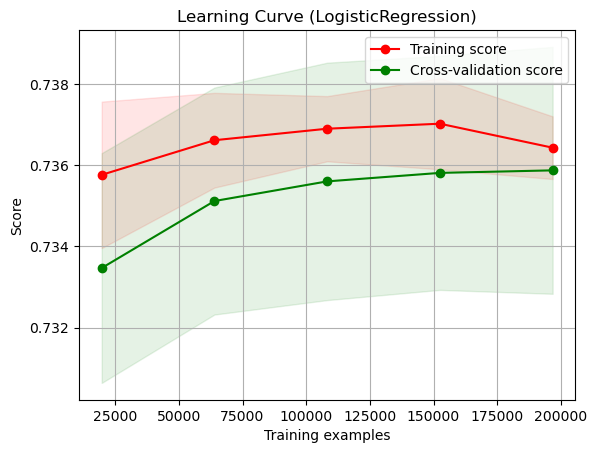

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.605217
320801        0.421463
373937        0.271026
119937        0.581686
234683        0.332136


8853

In [244]:
# Logistic Regression  featselection = 32

tag = "Feature selection"

lr_clf = LogisticRegression(random_state=42, class_weight='balanced')

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga'],
}

results_lr_featselect, test_results_lr_featselect = evaluate_model(
    model=lr_clf, 
    model_name="LogisticRegression", 
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test, 
    stratified_kfold=stratified_kfold, 
    scoring=scoring,
    param_grid=param_grid_lr,
    tag=tag
)
all_results.append(results_lr_featselect)
gc.collect()

[LightGBM] [Info] Number of positive: 19831, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3238
[LightGBM] [Info] Number of data points in the train set: 245964, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters for LightGBMClassifier: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100}
[LightGBM] [Info] Number of positive: 15865, number of negative: 180906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3234
[

Registered model 'LightGBMClassifier' already exists. Creating a new version of this model...
2024/05/23 23:45:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBMClassifier, version 2
Created version '2' of model 'LightGBMClassifier'.


LightGBMClassifier Results:
Precision: 0.16312897023460388
Recall: 0.6802480906205393
F1 Score: 0.26315113012034885
ROC AUC: 0.7523316111572864
Accuracy: 0.6928412216696757
Optimal Threshold: 0.53
Optimal Business Cost: 132128
Training Time: 57.51784110069275
Train AUC: 0.7709705297363381
Test AUC: 0.7597015796790016


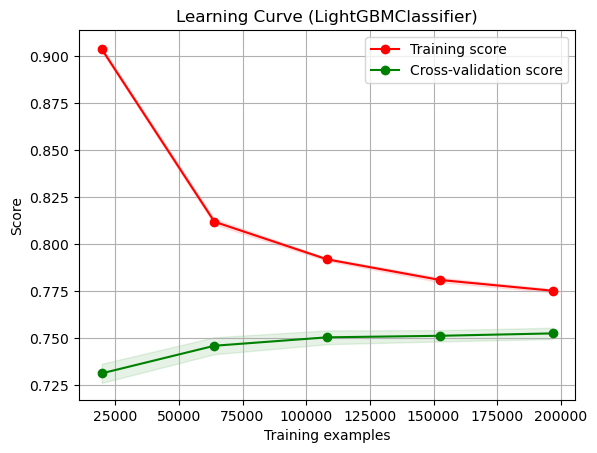

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.443312
320801        0.369803
373937        0.128743
119937        0.568634
234683        0.309392


4059

In [245]:
# LightGBMClassifier featselection = 32
lgb_clf = lgb.LGBMClassifier(
    nthread=4,
    class_weight='balanced',
    random_state=42
)
param_grid_lgb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.02, 0.05],
}

tag = "Feature selection"

results_lgbm_featselect, test_results_lgbm_featselect = evaluate_model(
    lgb_clf, 
    "LightGBMClassifier", 
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test, 
    stratified_kfold=stratified_kfold, 
    scoring=scoring,
    param_grid=param_grid_lgb,
    tag = tag
)
all_results.append(results_lgbm_featselect)
best_model.append(results_lgbm_featselect)
gc.collect()

In [246]:
# Ensemble des résultats 
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df

,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy,Optimal Threshold,Optimal Business Cost,Train AUC,Test AUC,Training Time
0,DummyClassifier,0.000000,0.000000,0.000000,0.500000,0.919374,0.01,198310,0.500000,0.500000,0.430731
1,LogisticRegression,0.155528,0.665725,0.252147,0.736291,0.681596,0.52,137315,0.737564,0.740306,139.597467
2,RandomForestClassifier,0.170609,0.612627,0.266890,0.739405,0.728639,0.49,135635,0.795739,0.744272,436.136262
3,LightGBMClassifier,0.163961,0.681358,0.264315,0.752967,0.694187,0.51,131963,0.771196,0.759713,71.066931
4,LogisticRegression,0.155295,0.658111,0.251291,0.733125,0.683803,0.53,138438,0.734299,0.736994,330.743347
5,LightGBMClassifier,0.405463,0.018960,0.036198,0.734815,0.918651,0.12,138191,0.745818,0.739792,173.445163
6,LogisticRegression,0.155379,0.666431,0.252003,0.735873,0.681014,0.53,137973,0.736378,0.739703,64.200292
7,LightGBMClassifier,0.163129,0.680248,0.263151,0.752332,0.692841,0.53,132128,0.770971,0.759702,57.517841


Les deux modèles présentent des forces dans différents aspects de la performance. Le LightGBM semble être le modèle plus performant en termes de précision, de score F1, de ROC AUC, et de coût métier tout en étant plus rapide à entraîner. Cela peut le rendre plus adapté pour des applications où la vitesse et l'efficacité de calcul sont critiques. La Régression Logistique, tout en étant légèrement moins performante sur ces métriques, offre une meilleure interprétabilité, ce qui peut être utile pour des contextes où comprendre les décisions du modèle est important.  

Le premier modèle LightGBMClassifier (Modèle 3) montre déjà d'excellentes performances, mais malgré une légère baisse des scores dans le dernier modèle LightGBMClassifier (Modèle 7) due à la sélection de caractéristiques, nous avons choisi de continuer avec ce dernier. La sélection de caractéristiques a permis de simplifier le modèle en réduisant la complexité et potentiellement en améliorant la généralisabilité, justifiant ainsi une légère concession en termes de performance brute pour un modèle plus robuste et efficace.

## Test Meilleur Modèle

Nous avons décidé de procéder à une optimisation approfondie des hyperparamètres de notre modèle LightGBM, un choix stratégique compte tenu de son efficacité démontrée dans les phases précédentes.

**Choix des Hyperparamètres**
- **Nombre d'Estimateurs (n_estimators) :** Le nombre d'arbres à construire est un paramètre fondamental dans les modèles de type boosting comme LightGBM. Un nombre plus élevé peut améliorer la précision du modèle mais augmente également le risque de surajustement ainsi que le temps de calcul.

- **Taux d'Apprentissage (learning rate) :** Il contrôle la vitesse à laquelle le modèle apprend. Un taux plus bas peut conduire à une meilleure généralisation mais nécessite plus d'arbres pour converger, alors qu'un taux plus élevé peut accélérer le processus d'apprentissage au risque de manquer la convergence optimale.


**Objectif de l'Optimisation**  
C'est de trouver le meilleur équilibre entre la puissance prédictive et la généralisation du modèle. En ajustant le nombre d'estimateurs, le taux d'apprentissage et le nombre de feuilles, nous cherchons à maximiser l'AUC ROC, garantissant ainsi que notre modèle distingue de manière optimale les clients à risque de ceux qui ne le sont pas.  

Cette optimisation est particulièrement pertinente dans le contexte du scoring de crédit où la capacité à prédire précisément le risque de défaut est cruciale pour minimiser les pertes financières tout en offrant des crédits de manière responsable et équitable.

[LightGBM] [Info] Number of positive: 19831, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3238
[LightGBM] [Info] Number of data points in the train set: 245964, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters for LightGBMClassifier: {'classifier__learning_rate': 0.055, 'classifier__n_estimators': 98}
[LightGBM] [Info] Number of positive: 15865, number of negative: 180906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3234
[

Registered model 'LightGBMClassifier' already exists. Creating a new version of this model...
2024/05/23 23:49:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBMClassifier, version 3
Created version '3' of model 'LightGBMClassifier'.


Modèle enregistré : LightGBMClassifier version 3 avec l'information 'Production'.
LightGBMClassifier Results:
Precision: 0.16360778908648102
Recall: 0.6801472206215651
F1 Score: 0.2637657968811985
ROC AUC: 0.7526788381799234
Accuracy: 0.6938576367737092
Optimal Threshold: 0.52
Optimal Business Cost: 132171
Training Time: 142.86084389686584
Train AUC: 0.7725463529045318
Test AUC: 0.7600151567891944


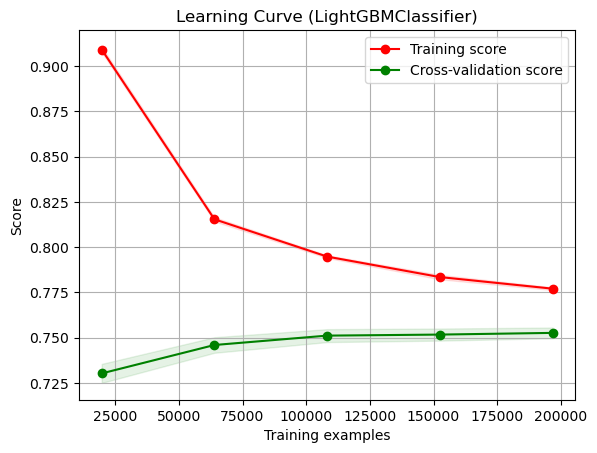

Prédictions pour les données de test:
            prediction
SK_ID_CURR            
360370        0.467577
320801        0.375582
373937        0.127801
119937        0.565708
234683        0.323817


3988

In [247]:
# LightGBMClassifier featselection = 32 - optimisation du modèle
lgb_clf = lgb.LGBMClassifier(
    nthread=4,
    class_weight='balanced',
    random_state=42
)
param_grid_lgb2 = {
    'classifier__n_estimators': [95, 96, 97, 98, 99, 100, 101, 102,103,104,105],
    'classifier__learning_rate': [0.05, 0.055, 0.06, 0.065]
}

tag = "Best Model"


results_lgbm_featselect_hyp, test_results_lgbm_featselect_hyp = evaluate_model(
    lgb_clf, 
    "LightGBMClassifier", 
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test, 
    stratified_kfold=stratified_kfold, 
    scoring=scoring,
    param_grid=param_grid_lgb2,
    tag = tag,
    model_alias = "Production"
)
best_model.append(results_lgbm_featselect_hyp)
gc.collect()

In [248]:
best_model_df = pd.concat(best_model, ignore_index=True)
best_model_df

,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy,Optimal Threshold,Optimal Business Cost,Train AUC,Test AUC,Training Time
0,LightGBMClassifier,0.163129,0.680248,0.263151,0.752332,0.692841,0.53,132128,0.770971,0.759702,57.517841
1,LightGBMClassifier,0.163608,0.680147,0.263766,0.752679,0.693858,0.52,132171,0.772546,0.760015,142.860844


Le modèle avec optimisation, bien que prenant plus de temps pour s'entraîner, offre de légères améliorations dans presque toutes les métriques de performance par rapport au best model de base, notamment en termes de précision, de rappel, de ROC AUC, et de précision.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19831, number of negative: 226133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 245964, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Le modèle a été enregistré à C:\Users\DUBUS\OneDrive\New\best_model.pkl
Le modèle a été chargé avec succès.


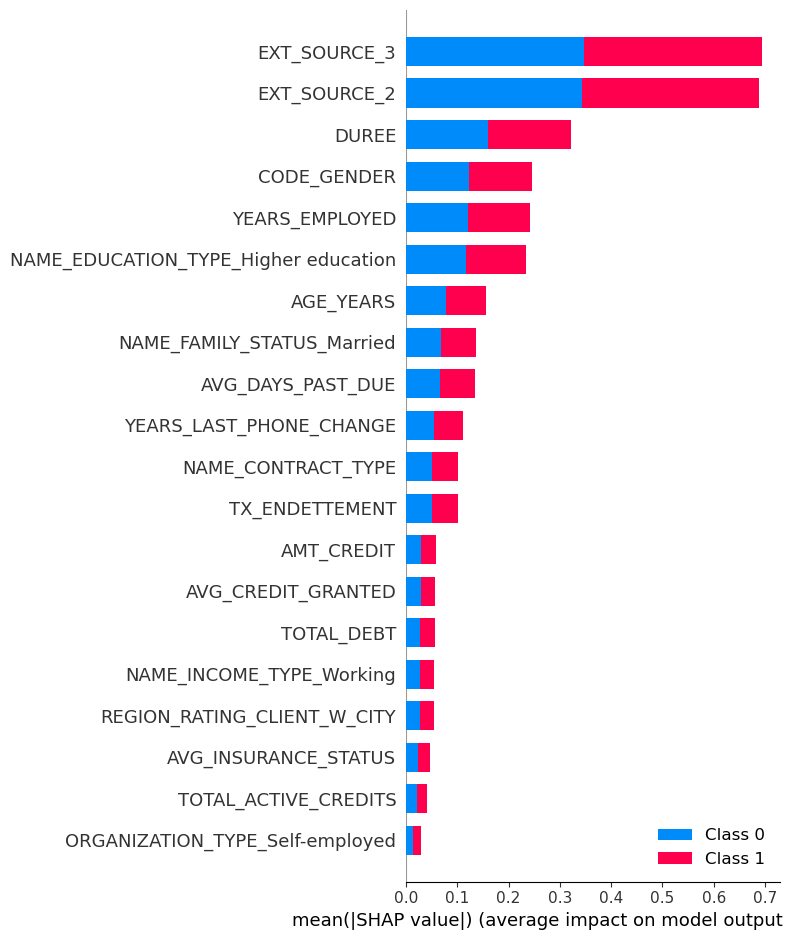

In [250]:
best_model_instance = lgb.LGBMClassifier(
    nthread=4,
    class_weight='balanced',
    random_state=42,
    n_estimators=98,  # Les meilleurs hyperparamètres trouvés
    learning_rate=0.055,  # Les meilleurs hyperparamètres trouvés
)

# Entraînement du modèle final
best_model_instance.fit(X_train_selected, y_train)

# Sauvegarde du modèle avec joblib
model_path = "C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Models\\best_model.pkl"
joblib.dump(best_model_instance, model_path)

print(f"Le modèle a été enregistré à {model_path}")

# Chargement du modèle à partir du fichier enregistré
best_model_loaded = joblib.load(model_path)
print("Le modèle a été chargé avec succès.")

# Utilisation de SHAP pour expliquer les prédictions du modèle
X_test_selected = pd.read_csv("C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Data\\test_selected_data.csv")
X_test_selected = X_test_selected.set_index('SK_ID_CURR')

# Création du explainer SHAP
explainer = shap.Explainer(best_model_loaded)

# Calcule des valeurs SHAP
shap_values = explainer.shap_values(X_test_selected)

# Affichage des importances des caractéristiques globales
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

Les résultats SHAP mettent en évidence l'influence prépondérante de facteurs tels que les scores externes (EXT_SOURCE_3 et EXT_SOURCE_2), la durée de l'emploi (YEARS_EMPLOYED), et d'autres variables démographiques et financières dans les décisions de scoring de crédit. En particulier, les scores externes se révèlent être des prédicteurs dominants, particulièrement pour les prédictions de risque élevé (classe 1), suggérant que des évaluations externes fiables sont des indicateurs clés du risque de crédit.

La durée de l'emploi et la durée du crédit (DUREE) jouent un rôle significatif, affectant différemment les classifications en risque faible (classe 0) et élevé. Cela indique que la stabilité de l'emploi est un bon prédicteur de la capacité de remboursement.

Des caractéristiques personnelles comme le genre et l'éducation (particulièrement l'éducation supérieure), ainsi que l'âge et les antécédents de paiements (AVG_DAYS_PAST_DUE), contribuent de manière importante à la modélisation du risque. Ces facteurs soulignent les différences comportementales qui peuvent affecter la solvabilité.

In [251]:
# Sauvegarde des valeurs SHAP avec joblib
shap_values_path = "C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Models\\shap_values.pkl"
joblib.dump(shap_values, shap_values_path)
print(f"Les valeurs SHAP ont été enregistrées à {shap_values_path}")

# Sauvegarde de l'explainer SHAP
explainer_path = "C:\\Users\\DUBUS\\OneDrive\\Scoring\\API\\Models\\explainer.pkl"
joblib.dump(explainer, explainer_path)
print(f"L'explainer SHAP a été enregistré à {explainer_path}")

Les valeurs SHAP ont été enregistrées à C:\Users\DUBUS\OneDrive\New\shap_values.pkl
L'explainer SHAP a été enregistré à C:\Users\DUBUS\OneDrive\New\explainer.pkl


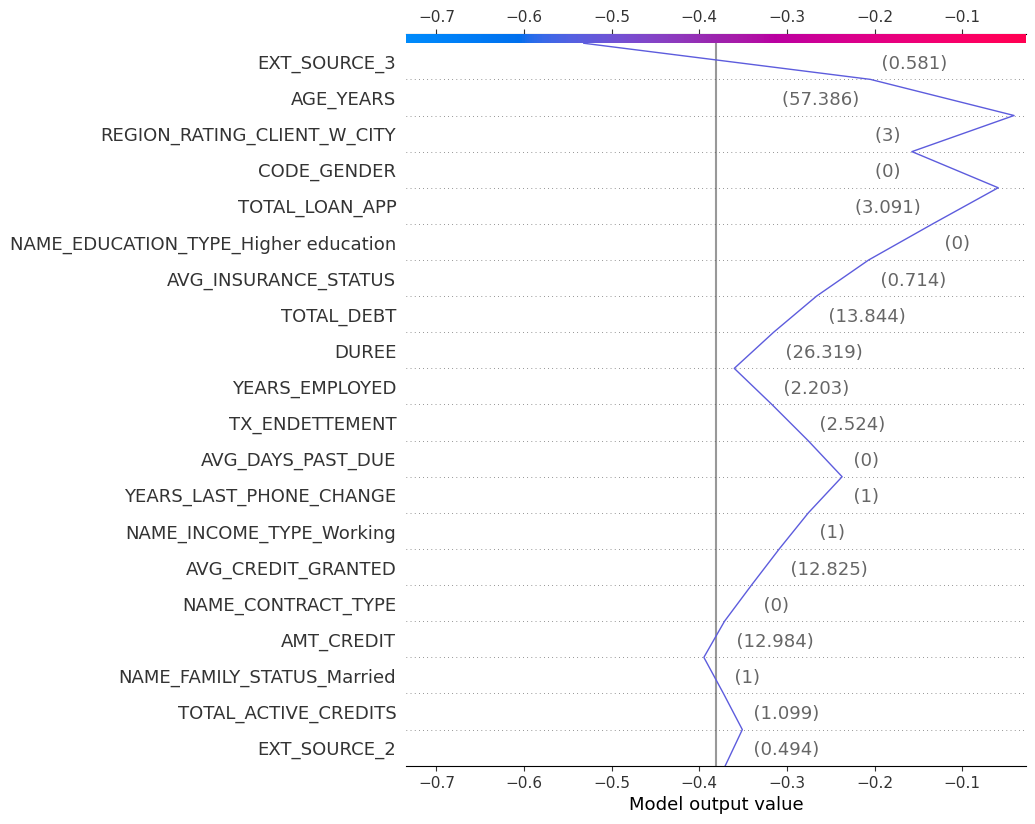

In [252]:
index = 1  # Index de l'exemple

# Affichage de la valeur SHAP pour l'exemple local
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][index], X_test_selected.iloc[index])

# Explication plus détaillée d'un exemple local
shap.decision_plot(explainer.expected_value[1], shap_values[1][index], X_test_selected.iloc[index])

L'analyse SHAP locale détaillée de cette instance de prédiction révèle comment chaque caractéristique influence spécifiquement la décision du modèle de scoring de crédit. Les caractéristiques les plus influentes comprennent EXT_SOURCE_3 et EXT_SOURCE_2, qui exercent des impacts opposés significatifs, illustrant l'importance des évaluations de risque de sources externes. L'âge du demandeur (AGE_YEARS) a également un impact extrêmement positif, soulignant que des facteurs démographiques tels que l'âge sont cruciaux pour évaluer la solvabilité.

Des éléments comme TOTAL_DEBT et YEARS_EMPLOYED augmentent la probabilité de prédiction favorable, suggérant que l'expérience de gestion de la dette et la stabilité de l'emploi sont perçues positivement. En revanche, une plus longue DUREE du crédit est vue comme un risque. L'éducation supérieure et le statut marital influencent également positivement la prédiction, indiquant que ces facteurs sociaux sont associés à une meilleure fiabilité de crédit.